# Описание экспериментов

Есть несколько наборов данных:
- metlin_8_25 - часть набора данных METLIN со значениями времени удерживания от 8 до 25 - самый большой набо данных (77889 строк)
- metlin_0_8 - часть набора данных METLIN со значениями времени удерживания от 0 до 8 (2068 строк)
- hilic - набор данных, собранных в другой лаборатории, время удерживания от 0 до 10 (880 строк)
- hilic_oxana - набор данных, собранный в третьей лаборатории (18 строк)

Задача:
обучить нейронную сеть на самом большом наборе данных, дообучить на остальных наборах, и предсказать как можно более близкие значения для набора данных hilic_oxana.



# Подключение необходимых библиотек

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.3 MB/s eta 0:00:00


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 19.8 MB/s eta 0:00:00


In [3]:
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import torch

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import xgboost

import lightgbm

import openpyxl
from openpyxl import load_workbook

from torch.utils.data import random_split

# Наборы данных

Загружаем уже подготовленные наборы данных, полученные из [METLIN](https://figshare.com/articles/dataset/The_METLIN_small_molecule_dataset_for_machine_learning-based_retention_time_prediction/8038913?file=18130628) и [HILIC]('https://pubs.acs.org/doi/abs/10.1021/acs.analchem.9b05765#').

Данные представляют собой две колонки:
- SMILES дополнены пробелами до длины 185 символов (максимальная длина строки для обоих наборов данных);
- RT (retention time) переведены в минуты.

In [5]:
metlin_0_8 = pd.read_csv('METLIN_0_8_to_OHE_to_CNN')
metlin_8_25 = pd.read_csv('METLIN_8_25_to_OHE_to_CNN')
hilic = pd.read_csv('HILIC_to_OHE_to_CNN')
metlin = pd.read_csv('METLIN_to_OHE_to_CNN')
hilic_oxana = pd.read_csv('HILIC_OXANA_to_OHE_to_CNN')

In [6]:
metlin_0_8

,smiles,rt
0,CCSC(=N)N ...,1.558333
1,CCN1CCc2[nH]c(=N)oc2CC1 ...,1.328333
2,CN1CCC(c2c[nH]c3ccc(O)cc23)CC1 ...,1.570000
3,N[C@H]1CCc2cc(O)c(O)cc2C1 ...,1.525000
4,NNC(=O)c1ccc(O)cc1 ...,1.936667
...,...,...
2063,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NC2CCN(C)CC...,1.398333
2064,CCC(=O)N1CCN([C@H]2CCN(CCN(C)C)C2=O)CC1 ...,1.315000
2065,Cc1oc2c(c1C(O)=NCCCn1cccn1)CN(C)CC2 ...,1.350000
2066,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NCCN2CCOCC2...,1.365000


In [7]:
metlin_8_25

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,9.845000
2,Oc1cccc2c(O)nccc12 ...,9.726667
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,9.650000
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12 ...,10.051667
...,...,...
77884,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,15.773333
77885,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,10.885000
77886,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,10.803333
77887,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,13.065000


In [8]:
hilic

,smiles,rt
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O ...,2.019083
1,CC1C(NC(CN1)C2=CC=CC=C2)C ...,2.607950
2,C1CCC(C(C1)O)O ...,4.876550
3,C1CCC(=O)C(=O)C1 ...,5.772267
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C ...,1.827733
...,...,...
875,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O ...,0.995283
876,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,4.640017
877,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,9.717716
878,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,1.507783


In [9]:
hilic_oxana

,smiles,rt
0,C1=NC=NN1 ...,4.6
1,C1(=NC(=NN1)N)N ...,7.6
2,C1=NN=CN1N ...,6.8
3,CC1=NC=NN1 ...,5.2
4,C1=NNN=C1 ...,3.4
5,C1=NNC(=N1)N ...,5.6
6,C1=CNN=C1 ...,3.4
7,CC1=CC=NN1 ...,3.5
8,CN1C=CC(=N1)N ...,4.5
9,CCC1=CC(=NN1)N ...,4.3


In [10]:
metlin_0_8.loc[:, 'rt'] = metlin_0_8['rt'].apply(lambda x: x * 60)
metlin_8_25.loc[:, 'rt'] = metlin_8_25['rt'].apply(lambda x: x * 60)
hilic.loc[:, 'rt'] = hilic['rt'].apply(lambda x: x * 60)
hilic_oxana.loc[:, 'rt'] = hilic_oxana['rt'].apply(lambda x: x * 60)

Посмотрим на распределение данных:

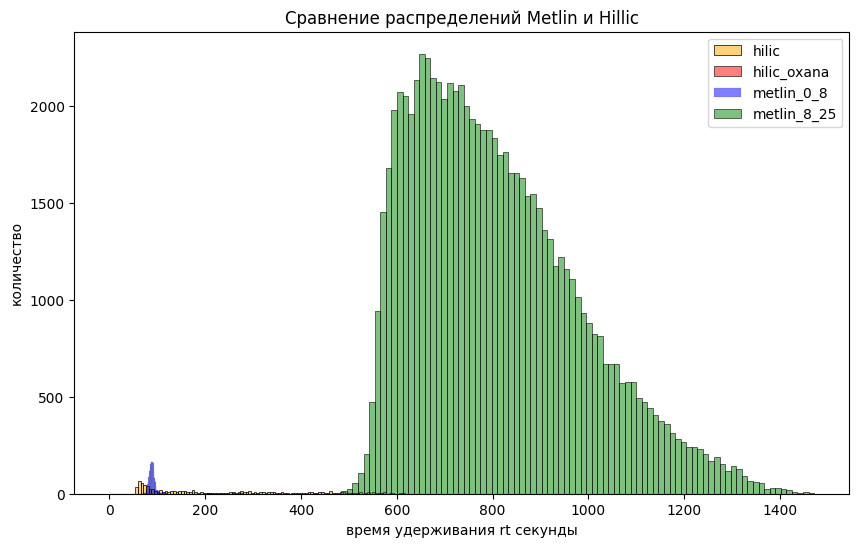

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

sns.histplot(hilic['rt'], label='hilic', color='orange', fill=True, alpha=0.5, bins=100)
sns.histplot(hilic_oxana['rt'], label='hilic_oxana', color='red', fill=True, alpha=0.5, bins=100)
sns.histplot(metlin_0_8['rt'], label='metlin_0_8', color='blue', fill=True, alpha=0.5)
sns.histplot(metlin_8_25['rt'], label='metlin_8_25', color='green', fill=True, alpha=0.5)

plt.title('Сравнение распределений Metlin и Hillic')
plt.xlabel('время удерживания rt секунды')
plt.ylabel('количество')

plt.legend()

plt.show()

## Преобразование Бокса-Кокса:

### Для набора данных metlin_8_25:

Параметр λ (lambda): -0.7251337287528066
Преобразованные данные: 
[1.36697666 1.36556727 1.36544847 ... 1.36644592 1.36806956 1.36577852]


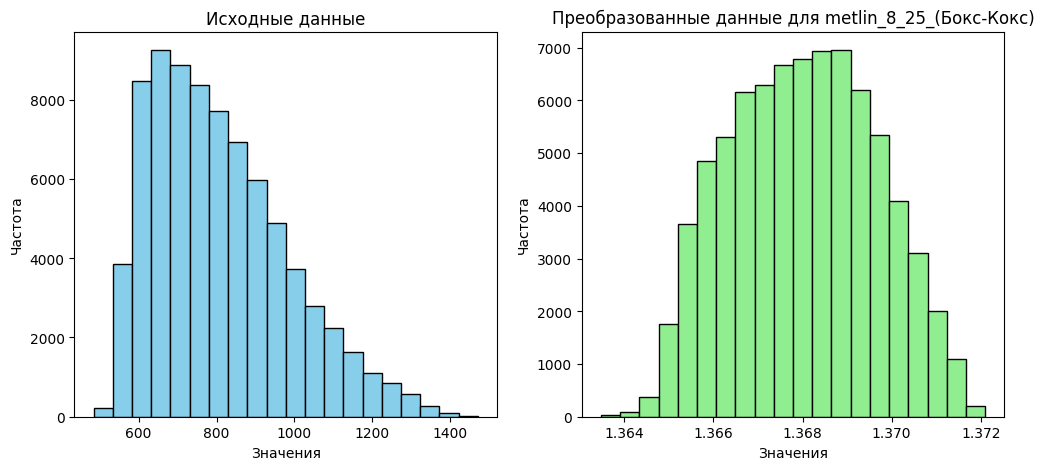

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Пример данных
data_8_25 = metlin_8_25['rt']

# Применение преобразования Бокса-Кокса
tr_data_8_25, lambda_8_25 = stats.boxcox(data_8_25)

# Вывод результата
print(f'Параметр λ (lambda): {lambda_8_25}')
print('Преобразованные данные: ')
print(tr_data_8_25)

# Визуализация исходных и преобразованных данных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data_8_25, bins=20, color='skyblue', edgecolor='black')
plt.title('Исходные данные')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(tr_data_8_25, bins=20, color='lightgreen', edgecolor='black')
plt.title('Преобразованные данные для metlin_8_25_(Бокс-Кокс)')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

In [13]:
metlin_8_25['rt'] = tr_data_8_25

In [14]:
metlin_8_25

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,1.366977
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,1.365567
2,Oc1cccc2c(O)nccc12 ...,1.365448
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,1.365370
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12 ...,1.365769
...,...,...
77884,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,1.369472
77885,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,1.366515
77886,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,1.366446
77887,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,1.368070


### Для набора данных metlin_0_8:

Параметр λ (lambda): 0.4764232723697015
Преобразованные данные: 
[16.13778052 14.80177809 16.20270047 ... 14.93255795 15.02245515
 14.84213623]


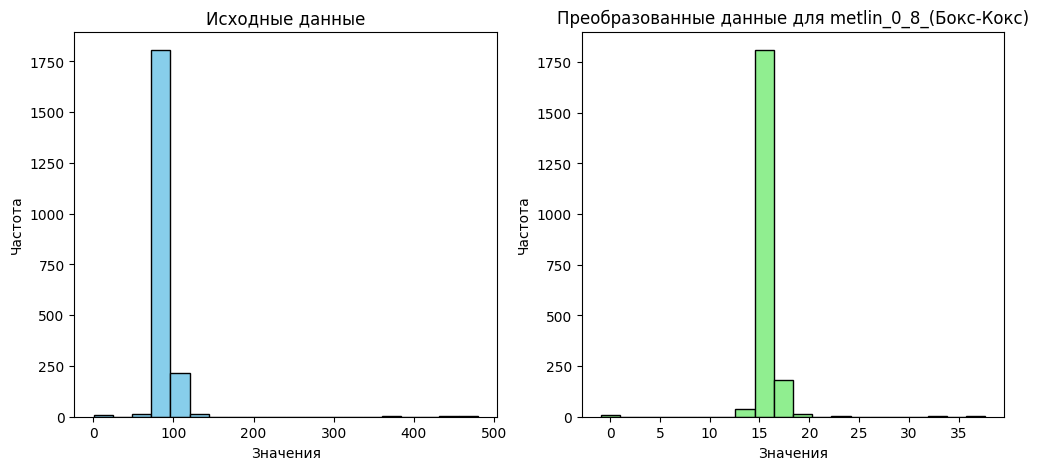

In [15]:
data_0_8 = metlin_0_8['rt']

# Применение преобразования Бокса-Кокса
tr_data_0_8, lambda_0_8 = stats.boxcox(data_0_8)

# Вывод результата
print(f'Параметр λ (lambda): {lambda_0_8}')
print('Преобразованные данные: ')
print(tr_data_0_8)

# Визуализация исходных и преобразованных данных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data_0_8, bins=20, color='skyblue', edgecolor='black')
plt.title('Исходные данные')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(tr_data_0_8, bins=20, color='lightgreen', edgecolor='black')
plt.title('Преобразованные данные для metlin_0_8_(Бокс-Кокс)')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

In [16]:
metlin_0_8['rt'] = tr_data_0_8

In [17]:
metlin_0_8

,smiles,rt
0,CCSC(=N)N ...,16.137781
1,CCN1CCc2[nH]c(=N)oc2CC1 ...,14.801778
2,CN1CCC(c2c[nH]c3ccc(O)cc23)CC1 ...,16.202700
3,N[C@H]1CCc2cc(O)c(O)cc2C1 ...,15.950880
4,NNC(=O)c1ccc(O)cc1 ...,18.127459
...,...,...
2063,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NC2CCN(C)CC...,15.220393
2064,CCC(=O)N1CCN([C@H]2CCN(CCN(C)C)C2=O)CC1 ...,14.720742
2065,Cc1oc2c(c1C(O)=NCCCn1cccn1)CN(C)CC2 ...,14.932558
2066,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NCCN2CCOCC2...,15.022455


In [64]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 6))

# sns.histplot(hilic['rt'], label='hilic', color='orange', fill=True, alpha=0.5, bins=100)
# sns.histplot(hilic_oxana['rt'], label='hilic_oxana', color='red', fill=True, alpha=0.5, bins=100)
# sns.histplot(metlin_0_8['rt'], label='metlin_0_8', color='blue', fill=True, alpha=0.5)
# sns.histplot(metlin_8_25['rt'], label='metlin_8_25', color='green', fill=True, alpha=0.5)

# plt.title('Сравнение распределений Metlin и Hillic')
# plt.xlabel('время удерживания rt секунды')
# plt.ylabel('количество')

# plt.legend()

# plt.show()

## One hot encoding

In [18]:
symbols_metlin = set(''.join(metlin['smiles']))
symbols_hilic = set(''.join(hilic['smiles']))
symbols = symbols_metlin.union(symbols_hilic)
symbols.add(' ')

In [19]:
char_to_index = {char: idx for idx, char in enumerate(symbols)}
num_unique_chars = len(symbols)

def smiles_to_one_hot(smiles, char_to_index, num_unique_chars):
    one_hot = np.zeros((len(smiles), num_unique_chars), dtype=np.float32)
    for i, char in enumerate(smiles):
        one_hot[i, char_to_index[char]] = 1
    return np.transpose(one_hot)

### Проверочный пример для отладки функции перевода в One Hot Encoding:

In [ ]:
line = ''.join(char_to_index.keys())
line

's2]+rn-Ioi(#96C8S= l4@H\\3)7/Fc1[BOP5N'

In [ ]:
arr = smiles_to_one_hot('O=CC1C    ', char_to_index, num_unique_chars)

In [ ]:
arr.shape

(37, 10)

In [ ]:
for r in range(35):
    if r == 0:
        print('  O = C c 1 C     ')
    print(line[r], end = ' ')
    for c in range(10):
        print(round(arr[r][c]), end=' ')
    print()

  O = C c 1 C     
s 0 0 0 0 0 0 0 0 0 0 
2 0 0 0 0 0 0 0 0 0 0 
] 0 0 0 0 0 0 0 0 0 0 
+ 0 0 0 0 0 0 0 0 0 0 
r 0 0 0 0 0 0 0 0 0 0 
n 0 0 0 0 0 0 0 0 0 0 
- 0 0 0 0 0 0 0 0 0 0 
I 0 0 0 0 0 0 0 0 0 0 
o 0 0 0 0 0 0 0 0 0 0 
i 0 0 0 0 0 0 0 0 0 0 
( 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
9 0 0 0 0 0 0 0 0 0 0 
6 0 0 0 0 0 0 0 0 0 0 
C 0 0 1 1 0 1 0 0 0 0 
8 0 0 0 0 0 0 0 0 0 0 
S 0 0 0 0 0 0 0 0 0 0 
= 0 1 0 0 0 0 0 0 0 0 
  0 0 0 0 0 0 1 1 1 1 
l 0 0 0 0 0 0 0 0 0 0 
4 0 0 0 0 0 0 0 0 0 0 
@ 0 0 0 0 0 0 0 0 0 0 
H 0 0 0 0 0 0 0 0 0 0 
\ 0 0 0 0 0 0 0 0 0 0 
3 0 0 0 0 0 0 0 0 0 0 
) 0 0 0 0 0 0 0 0 0 0 
7 0 0 0 0 0 0 0 0 0 0 
/ 0 0 0 0 0 0 0 0 0 0 
F 0 0 0 0 0 0 0 0 0 0 
c 0 0 0 0 0 0 0 0 0 0 
1 0 0 0 0 1 0 0 0 0 0 
[ 0 0 0 0 0 0 0 0 0 0 
B 0 0 0 0 0 0 0 0 0 0 
O 1 0 0 0 0 0 0 0 0 0 
P 0 0 0 0 0 0 0 0 0 0 


### Перевод в one hot encoding:

In [20]:
metlin_0_8_one_hot = []
for smile in metlin_0_8['smiles']:
    metlin_0_8_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [21]:
metlin_8_25_one_hot = []
for smile in metlin_8_25['smiles']:
    metlin_8_25_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [22]:
hilic_one_hot = []
for smile in hilic['smiles']:
    hilic_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [23]:
maxlen = 185
for i in range(18):
    if len(hilic_oxana['smiles'].values[i]) < maxlen:
        hilic_oxana['smiles'].values[i] = hilic_oxana['smiles'].values[i].ljust(maxlen)

In [24]:
hilic_oxana_one_hot = []
for smile in hilic_oxana['smiles']:
    hilic_oxana_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [25]:
metlin_0_8_one_hot[1].shape

(37, 185)

In [26]:
metlin_8_25_one_hot[1].shape

(37, 185)

In [27]:
hilic_one_hot[1].shape

(37, 185)

In [28]:
metlin_0_8_tensor = [torch.tensor(metlin_0_8_one_hot[i]) for i in range(2068)]
metlin_8_25_tensor = [torch.tensor(metlin_8_25_one_hot[i]) for i in range(77889)]
hilic_tensor = [torch.tensor(hilic_one_hot[i]) for i in range(800)]
hilic_oxana_tensor = [torch.tensor(hilic_oxana_one_hot[i]) for i in range(18)]

Теперь набор данных готов к подаче в нейронную сеть.

## Формирование наборов данных посредством DataLoader

In [29]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 14.2 MB/s eta 0:00:00


In [ ]:
#!pip install --upgrade pip

In [30]:
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.nn.modules.pooling import MaxPool2d
from torchvision import datasets, transforms, utils
from IPython.display import clear_output
from torchmetrics import MeanAbsoluteError

In [31]:
from torch.utils.data import Dataset, DataLoader, Subset

In [32]:
class DataToNN(Dataset):
    def __init__(self, data_tensor, data_to_rt):
        self.data = data_tensor
        self.labels = data_to_rt['rt']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_sample = self.data[idx]
        label_sample = torch.tensor(self.labels.iloc[idx])
        return data_sample, label_sample

In [33]:
metlin_0_8_dataset = DataToNN(metlin_0_8_tensor, metlin_0_8)
metlin_8_25_dataset = DataToNN(metlin_8_25_tensor, metlin_8_25)
hilic_dataset = DataToNN(hilic_tensor, hilic)
hilic_oxana_dataset = DataToNN(hilic_oxana_tensor, hilic_oxana)

In [34]:
it = next(iter(metlin_0_8_dataset))
imgs, labels = it
print(labels)

tensor(16.1378, dtype=torch.float64)


In [35]:
it = next(iter(hilic_dataset))
imgs, labels = it
print(labels)

tensor(121.1450, dtype=torch.float64)


In [36]:
from torch.utils.data import random_split

In [37]:
dataset_size = len(metlin_0_8_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(dataset_size),[train_size, val_size, test_size])

metlin_0_8_train_set = Subset(metlin_0_8_dataset, train_indices)
metlin_0_8_val_set = Subset(metlin_0_8_dataset, val_indices)
metlin_0_8_test_set = Subset(metlin_0_8_dataset, test_indices)


batch_size = 16

metlin_0_8_train_loader = DataLoader(metlin_0_8_train_set, batch_size=batch_size, shuffle=True)
metlin_0_8_val_loader = DataLoader(metlin_0_8_val_set, batch_size=batch_size, shuffle=False)
metlin_0_8_test_loader = DataLoader(metlin_0_8_test_set, batch_size=batch_size, shuffle=False)

In [38]:
dataset_size = len(metlin_8_25_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(dataset_size),[train_size, val_size, test_size])

metlin_8_25_train_set = Subset(metlin_8_25_dataset, train_indices)
metlin_8_25_val_set = Subset(metlin_8_25_dataset, val_indices)
metlin_8_25_test_set = Subset(metlin_8_25_dataset, test_indices)


batch_size = 16

metlin_8_25_train_loader = DataLoader(metlin_8_25_train_set, batch_size=batch_size, shuffle=True)
metlin_8_25_val_loader = DataLoader(metlin_8_25_val_set, batch_size=batch_size, shuffle=False)
metlin_8_25_test_loader = DataLoader(metlin_8_25_test_set, batch_size=batch_size, shuffle=False)

In [39]:
dataset_size = len(hilic_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(dataset_size),[train_size, val_size, test_size])

hilic_train_set = Subset(hilic_dataset, train_indices)
hilic_val_set = Subset(hilic_dataset, val_indices)
hilic_test_set = Subset(hilic_dataset, test_indices)


batch_size = 16

hilic_train_loader = DataLoader(hilic_train_set, batch_size=batch_size, shuffle=True)
hilic_val_loader = DataLoader(hilic_val_set, batch_size=batch_size, shuffle=False)
hilic_test_loader = DataLoader(hilic_test_set, batch_size=batch_size, shuffle=False)

In [40]:
hilic_oxana_loader = DataLoader(hilic_oxana_dataset, batch_size=18, shuffle=True)

# Архитектура и обучение нейронной сети

Важно отметить, что субдискретизация выполняется по каждому из каналов отдельно, в результате чего количество каналов не меняется, в отличие от применения фильтра при свёртке.

Архитектура
- conv1d (на вход 20-30 каналов (по числу возможных символов в SMILES), на выход 300 каналов)
- conv1d (на вход 300 на выход 300 каналов)
- average pooling (не макс пулинг)
- dense (in=300;o o ut=600)
- dense(in=600, out = 1)

loss - MAE, активация ReLU везде кроме последнего

In [41]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = torch.nn.Sequential(
            nn.Conv1d(in_channels=37, out_channels=300, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=177, stride=1),
            nn.Flatten(),
            nn.Linear(300, 600),
            nn.ReLU(),
            nn.Linear(600, 1),
        )

    def forward(self, x):
        #x = x.unsqueeze(1)
        # for i, layer in enumerate(self.layers_stack):
        #    x = layer(x)
        #    print(f'After layer {i} ({layer.__class__.__name__}): {x.shape}')  # Выводим размерность после слоя
        # return x
        scores = self.layers_stack(x)
        return scores

In [43]:
model_test = CNN()

input_test = torch.randn(16, 37, 185)  # Размер батча = 1, размер изображения = 37x185

output = model_test(input_test)

### Непосредственно обучение нейронной сети:

In [44]:
class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [45]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        labels = labels.unsqueeze(1) ## добавила
        pred =  model(imgs.to(device))
        loss =  criterion(pred, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

        # accumulating predictions and true labels to calculate score function
        score_function.update(pred.cpu(), labels)

    train_loss /= num_batches

    train_score = score_function.compute().item()
    score_function.reset()

    return train_loss, train_score

In [46]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0

    with torch.no_grad():
        for smiles, labels in dataloader:
            labels = labels.unsqueeze(1) ## добавила
            pred =  model(smiles.to(device))
            loss =  criterion(pred, labels.to(device))

            val_loss += loss.item()

            # accumulating predictions and true labels to calculate score function
            score_function.update(pred.cpu(), labels)

    val_loss /= num_batches

    val_score = score_function.compute().item()
    score_function.reset()

    return val_loss, val_score

In [47]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score =  train_loop(train_loader, model, criterion, optimizer, score_function, device)
        val_loss, val_score = val_loop(val_loader, model, criterion, score_function, device)

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


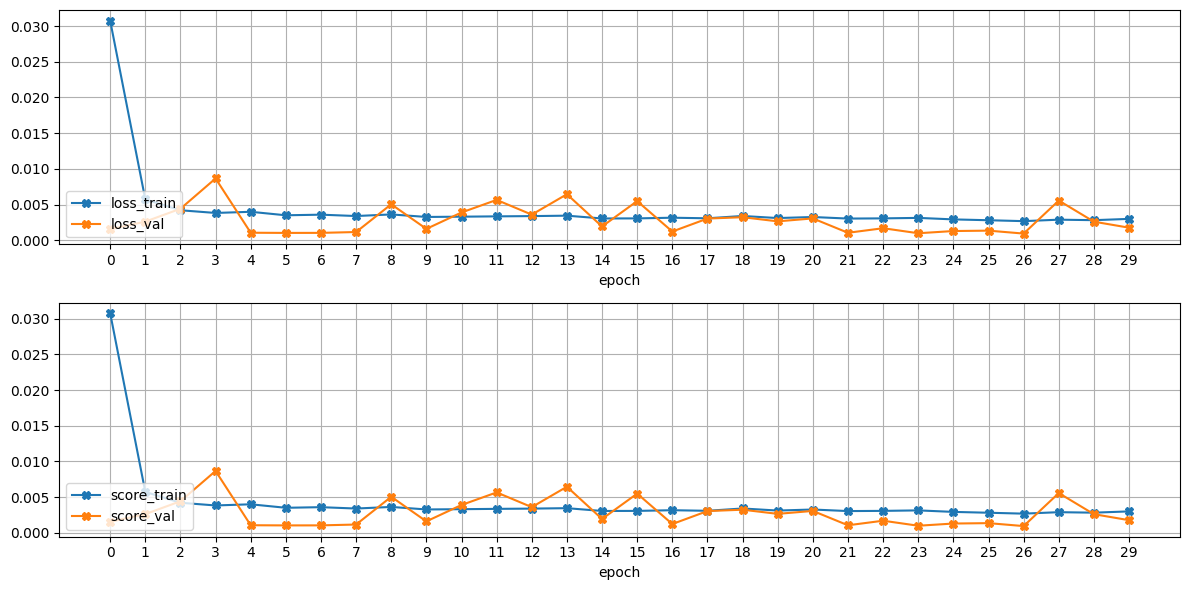

In [49]:
model_1 = CNN().to(device)

#score_function = torchmetrics.MeanAbsolutePercentageError()
score_function = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=0.002)
criterion = nn.L1Loss()

pp = train(
    model_1,
    metlin_8_25_train_loader,
    metlin_8_25_val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=30,
)

In [50]:
accuracy = pp.history_dict["loss_val"][-1]
print(f"MAE {accuracy:.5f}")

MAE 0.00177


In [51]:
test_loss, test_score = val_loop(metlin_8_25_test_loader, model_1, criterion, score_function, device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.001732700342375774, test_score = 0.0017327101668342948


Обратное преобразование Бокса-Кокса для тестирования на других наборах данных:

In [52]:
def inverse_boxcox(transformed_data, lambda_value):
    if lambda_value == 0:
        return np.exp(transformed_data)  # Обратное преобразование для lambda = 0
    else:
        return (lambda_value * transformed_data + 1) ** (1 / lambda_value)  # Обратное преобразование для lambda != 0

In [53]:
mae_bc = 0
for imgs, labels in metlin_8_25_test_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_8_25)
        mae_bc += (criterion(pred, labels.to(device)))
print(mae_bc / len(metlin_8_25_test_loader))

tensor(646.8914, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [54]:
preds = []
mae_bc = 0
for imgs, labels in metlin_0_8_test_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, inverse_boxcox(labels.to(device), lambda_0_8))
print(mae_bc / len(metlin_0_8_test_loader))

tensor(444.5650, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [55]:
preds = []
mae_bc = 0
for imgs, labels in hilic_oxana_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_oxana_loader))

tensor(230.6251, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [56]:
preds = []
mae_bc = 0
for imgs, labels in hilic_test_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_test_loader))

tensor(345.5722, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [124]:
# test_loss, test_score = val_loop(metlin_0_8_test_loader, model_1, criterion, score_function, device)
# print(f'{test_loss = }, {test_score = }')

In [125]:
# test_loss, test_score = val_loop(hilic_test_loader, model_1, criterion, score_function, device)
# print(f'{test_loss = }, {test_score = }')

In [126]:
# test_loss, test_score = val_loop(hilic_oxana_loader, model_1, criterion, score_function, device)
# print(f'{test_loss = }, {test_score = }')

Сохраним веса обученной модели:

In [57]:
torch.save(model_1.state_dict(), 'model_weights_best.pth')

In [128]:
# test_loss, test_score = val_loop(metlin_0_8_test_loader, model_1, criterion, score_function, device)
# print(f'{test_loss = }, {test_score = }')

# Дообучение нейронной сети различными способами:

## Экперимент 1

Дообучение на metlin_0_8 с последующим дообучением на hilic и тестированием на hilic_oxana без замораживания весов и без добавления новых слоёв.

In [58]:
model_1.eval()

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is running on: ', device)

Device is running on:  cuda


In [60]:
from tqdm import tqdm
model_1.to(device)

score_function = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=0.0001)
criterion = nn.L1Loss()

def train_model(model, num_epochs=1, lr=1e-3, data=metlin_0_8_train_loader):
    #criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(data):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [61]:
train_model(model_1, num_epochs=50, lr=0.0001, data=metlin_0_8_train_loader)

  0%|          | 0/91 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 88%|████████▊ | 80/91 [00:00<00:00, 174.92it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 91/91 [00:00<00:00, 157.84it/s]



Epoch 0 Loss 14.207220615644978


100%|██████████| 91/91 [00:00<00:00, 224.29it/s]



Epoch 1 Loss 14.181170594704525


100%|██████████| 91/91 [00:00<00:00, 222.72it/s]



Epoch 2 Loss 12.22205985275332


100%|██████████| 91/91 [00:00<00:00, 224.78it/s]



Epoch 3 Loss 13.554225770409916


100%|██████████| 91/91 [00:00<00:00, 217.84it/s]



Epoch 4 Loss 12.759159014908137


100%|██████████| 91/91 [00:00<00:00, 223.07it/s]



Epoch 5 Loss 11.149560570901238


100%|██████████| 91/91 [00:00<00:00, 216.34it/s]



Epoch 6 Loss 6.345170268455629


100%|██████████| 91/91 [00:00<00:00, 222.70it/s]



Epoch 7 Loss 0.8914169704543735


100%|██████████| 91/91 [00:00<00:00, 220.86it/s]



Epoch 8 Loss 0.29872535164454467


100%|██████████| 91/91 [00:00<00:00, 217.47it/s]



Epoch 9 Loss 0.7314124420316618


100%|██████████| 91/91 [00:00<00:00, 221.17it/s]



Epoch 10 Loss 0.7858312846119061


100%|██████████| 91/91 [00:00<00:00, 219.34it/s]



Epoch 11 Loss 0.3683440627185096


100%|██████████| 91/91 [00:00<00:00, 220.11it/s]



Epoch 12 Loss 0.3281326679597341


100%|██████████| 91/91 [00:00<00:00, 208.80it/s]



Epoch 13 Loss 0.19674820046185656


100%|██████████| 91/91 [00:00<00:00, 220.76it/s]



Epoch 14 Loss 0.7416818830232766


100%|██████████| 91/91 [00:00<00:00, 221.47it/s]



Epoch 15 Loss 3.09778263324607


100%|██████████| 91/91 [00:00<00:00, 215.66it/s]



Epoch 16 Loss 0.4097632890154417


100%|██████████| 91/91 [00:00<00:00, 221.10it/s]



Epoch 17 Loss 2.623801840805398


100%|██████████| 91/91 [00:00<00:00, 213.02it/s]



Epoch 18 Loss 0.49556199012557023


100%|██████████| 91/91 [00:00<00:00, 220.74it/s]



Epoch 19 Loss 2.7885339316028657


100%|██████████| 91/91 [00:00<00:00, 215.20it/s]



Epoch 20 Loss 0.5499043207153945


100%|██████████| 91/91 [00:00<00:00, 207.09it/s]



Epoch 21 Loss 2.7783137047790074


100%|██████████| 91/91 [00:00<00:00, 201.16it/s]



Epoch 22 Loss 0.47028585651699606


100%|██████████| 91/91 [00:00<00:00, 203.85it/s]



Epoch 23 Loss 0.7927218947468945


100%|██████████| 91/91 [00:00<00:00, 205.06it/s]



Epoch 24 Loss 0.339122081377325


100%|██████████| 91/91 [00:00<00:00, 191.72it/s]



Epoch 25 Loss 0.3222716054201061


100%|██████████| 91/91 [00:00<00:00, 204.45it/s]



Epoch 26 Loss 0.7757312617634124


100%|██████████| 91/91 [00:00<00:00, 192.23it/s]



Epoch 27 Loss 0.3456472058213866


100%|██████████| 91/91 [00:00<00:00, 210.19it/s]



Epoch 28 Loss 0.2643403400278809


100%|██████████| 91/91 [00:00<00:00, 217.36it/s]



Epoch 29 Loss 0.6383114945799842


100%|██████████| 91/91 [00:00<00:00, 214.57it/s]



Epoch 30 Loss 0.6752870479368729


100%|██████████| 91/91 [00:00<00:00, 218.25it/s]



Epoch 31 Loss 0.7320170562097925


100%|██████████| 91/91 [00:00<00:00, 211.57it/s]



Epoch 32 Loss 0.379148623439524


100%|██████████| 91/91 [00:00<00:00, 214.54it/s]



Epoch 33 Loss 0.4834347485251711


100%|██████████| 91/91 [00:00<00:00, 213.41it/s]



Epoch 34 Loss 0.3290183406766453


100%|██████████| 91/91 [00:00<00:00, 219.94it/s]



Epoch 35 Loss 0.7249241566777697


100%|██████████| 91/91 [00:00<00:00, 215.38it/s]



Epoch 36 Loss 0.5668216887058957


100%|██████████| 91/91 [00:00<00:00, 214.98it/s]



Epoch 37 Loss 0.44104996192819584


100%|██████████| 91/91 [00:00<00:00, 218.38it/s]



Epoch 38 Loss 0.7157615793356338


100%|██████████| 91/91 [00:00<00:00, 214.63it/s]



Epoch 39 Loss 0.7084612066422303


100%|██████████| 91/91 [00:00<00:00, 220.25it/s]



Epoch 40 Loss 3.4466600543563266


100%|██████████| 91/91 [00:00<00:00, 215.67it/s]



Epoch 41 Loss 0.8007818059908873


100%|██████████| 91/91 [00:00<00:00, 213.90it/s]



Epoch 42 Loss 0.9086299509582675


100%|██████████| 91/91 [00:00<00:00, 212.31it/s]



Epoch 43 Loss 0.5133905742509571


100%|██████████| 91/91 [00:00<00:00, 213.41it/s]



Epoch 44 Loss 0.4994324104980213


100%|██████████| 91/91 [00:00<00:00, 216.58it/s]



Epoch 45 Loss 1.1165671302048652


100%|██████████| 91/91 [00:00<00:00, 212.43it/s]



Epoch 46 Loss 0.5343934817263384


100%|██████████| 91/91 [00:00<00:00, 215.41it/s]



Epoch 47 Loss 0.467933979420615


100%|██████████| 91/91 [00:00<00:00, 210.46it/s]



Epoch 48 Loss 0.4973000903196885


100%|██████████| 91/91 [00:00<00:00, 214.14it/s]


Epoch 49 Loss 0.44761636666652166


In [62]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_1, criterion, score_function, device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.6377425357316178, test_score = 0.6377425789833069


In [64]:
preds_hilic = []
mae_bc = 0
for imgs, labels in hilic_train_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_0_8)
        preds_hilic.append(pred)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_train_loader))

tensor(144.1402, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [65]:
preds_hilic

[tensor([[90.5772],
         [90.4954],
         [88.7759],
         [91.2001],
         [86.4685],
         [89.4166],
         [89.3159],
         [89.9779],
         [87.5670],
         [88.0770],
         [89.0211],
         [89.7059],
         [88.5509],
         [90.3115],
         [89.8239],
         [87.7501]], device='cuda:0', grad_fn=<PowBackward0>),
 tensor([[87.8212],
         [91.8301],
         [89.5668],
         [92.2441],
         [89.2585],
         [87.3873],
         [87.2901],
         [89.2353],
         [89.5889],
         [88.9654],
         [89.7331],
         [89.8901],
         [88.3693],
         [89.7360],
         [89.2590],
         [89.0365]], device='cuda:0', grad_fn=<PowBackward0>),
 tensor([[88.6587],
         [88.6550],
         [88.9159],
         [90.4642],
         [89.3398],
         [87.6193],
         [90.2885],
         [88.5536],
         [89.6838],
         [89.9313],
         [89.7148],
         [92.4456],
         [91.9893],
         [87.8

In [76]:
#preds_hilic = preds_hilic.to(cpu)
hilic_array = [tensor.detach().cpu().numpy() for tensor in preds_hilic]

# Объединяем массивы в DataFrame
# Примечание: если размеры тензоров различаются, используйте pd.concat.
df_hilic = pd.DataFrame(np.concatenate(hilic_array, axis=0), columns=['Value'])


In [77]:
df_hilic

,Value
0,90.577232
1,90.495361
2,88.775925
3,91.200142
4,86.468521
...,...
555,89.539619
556,89.465675
557,90.622803
558,88.719330


In [66]:
preds = []
mae_bc = 0
for imgs, labels in hilic_oxana_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_1(imgs.to(device)), lambda_0_8)
        preds.append(pred)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_oxana_loader))

tensor(309.8628, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [67]:
preds

[tensor([[87.5357],
         [87.9740],
         [86.7604],
         [87.8811],
         [86.6205],
         [87.3917],
         [88.4183],
         [87.2868],
         [87.2332],
         [87.9000],
         [87.9589],
         [87.3181],
         [87.9541],
         [87.3911],
         [87.9103],
         [86.6080],
         [87.2602],
         [87.0669]], device='cuda:0', grad_fn=<PowBackward0>)]

In [ ]:
hilic_oxana

In [171]:
torch.save(model_1.state_dict(), 'model_weights_after_tuning.pth')

## Экперимент 2
Дообучение на metlin_0_8, потом hilic, тестирование на hilic_oxana с изменением последнего слоя.

Загружаем обученную на наборе данных metlin_8_25 модель:

In [143]:
model_2 = CNN().to(device)
model_2.load_state_dict(torch.load('model_weights_best.pth'))

<ipython-input-143-dfd9a2fc79c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load('model_weights_best.pth'))


<All keys matched successfully>

In [144]:
model_2

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

Замораживаем веса модели:

In [145]:
for param in model_2.parameters():
    param.requires_grad = False

Заменим последний слой на аналогичный по размерности:

In [146]:
from torch import nn

model_2.layers_stack[8] = nn.Linear(600, 1, bias=True)

Функция для обучения модели:

In [147]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)


def train_model(model, num_epochs=1, lr=0.001, train_loader=metlin_0_8_train_loader):
    score_function = torchmetrics.MeanAbsoluteError()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.L1Loss()
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(train_loader):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [148]:
train_model(model_2, num_epochs=50, lr=0.001, train_loader=metlin_0_8_train_loader)

  0%|          | 0/91 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 82%|████████▏ | 75/91 [00:00<00:00, 246.51it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 91/91 [00:00<00:00, 250.82it/s]



Epoch 0 Loss 15.48536494072709


100%|██████████| 91/91 [00:00<00:00, 287.05it/s]



Epoch 1 Loss 15.937049702498426


100%|██████████| 91/91 [00:00<00:00, 308.47it/s]



Epoch 2 Loss 15.386814530698254


100%|██████████| 91/91 [00:00<00:00, 320.76it/s]



Epoch 3 Loss 15.197967930866694


100%|██████████| 91/91 [00:00<00:00, 317.02it/s]



Epoch 4 Loss 14.956512888254109


100%|██████████| 91/91 [00:00<00:00, 315.48it/s]



Epoch 5 Loss 15.309526442670764


100%|██████████| 91/91 [00:00<00:00, 314.25it/s]



Epoch 6 Loss 15.066324646732502


100%|██████████| 91/91 [00:00<00:00, 327.10it/s]



Epoch 7 Loss 14.617658027966158


100%|██████████| 91/91 [00:00<00:00, 313.01it/s]



Epoch 8 Loss 14.935474252889353


100%|██████████| 91/91 [00:00<00:00, 321.78it/s]



Epoch 9 Loss 14.874969898978577


100%|██████████| 91/91 [00:00<00:00, 317.10it/s]



Epoch 10 Loss 14.64166744695206


100%|██████████| 91/91 [00:00<00:00, 312.09it/s]



Epoch 11 Loss 14.394425899587848


100%|██████████| 91/91 [00:00<00:00, 321.91it/s]



Epoch 12 Loss 15.182374787142031


100%|██████████| 91/91 [00:00<00:00, 281.30it/s]



Epoch 13 Loss 14.468764414791162


100%|██████████| 91/91 [00:00<00:00, 109.35it/s]



Epoch 14 Loss 14.23453542154871


100%|██████████| 91/91 [00:01<00:00, 86.80it/s]



Epoch 15 Loss 14.579783712020735


100%|██████████| 91/91 [00:00<00:00, 161.76it/s]



Epoch 16 Loss 13.819352950437104


100%|██████████| 91/91 [00:00<00:00, 164.67it/s]



Epoch 17 Loss 14.321092173937561


100%|██████████| 91/91 [00:00<00:00, 185.81it/s]



Epoch 18 Loss 14.025771884145662


100%|██████████| 91/91 [00:00<00:00, 206.27it/s]



Epoch 19 Loss 13.851905957308276


100%|██████████| 91/91 [00:00<00:00, 202.74it/s]



Epoch 20 Loss 13.846573058677917


100%|██████████| 91/91 [00:00<00:00, 133.01it/s]



Epoch 21 Loss 13.751692128447779


100%|██████████| 91/91 [00:01<00:00, 85.04it/s]



Epoch 22 Loss 13.596702678661233


100%|██████████| 91/91 [00:01<00:00, 87.81it/s]



Epoch 23 Loss 13.448352755775412


100%|██████████| 91/91 [00:00<00:00, 254.41it/s]



Epoch 24 Loss 13.40631133098093


100%|██████████| 91/91 [00:00<00:00, 297.15it/s]



Epoch 25 Loss 12.27826672728925


100%|██████████| 91/91 [00:00<00:00, 305.57it/s]



Epoch 26 Loss 13.210651890055031


100%|██████████| 91/91 [00:00<00:00, 308.50it/s]



Epoch 27 Loss 13.074714344229792


100%|██████████| 91/91 [00:00<00:00, 318.15it/s]



Epoch 28 Loss 13.207573963670182


100%|██████████| 91/91 [00:00<00:00, 314.27it/s]



Epoch 29 Loss 13.098597135930502


100%|██████████| 91/91 [00:00<00:00, 304.98it/s]



Epoch 30 Loss 12.630029632468256


100%|██████████| 91/91 [00:00<00:00, 328.98it/s]



Epoch 31 Loss 12.534796869869215


100%|██████████| 91/91 [00:00<00:00, 328.63it/s]



Epoch 32 Loss 12.59091360089688


100%|██████████| 91/91 [00:00<00:00, 316.44it/s]



Epoch 33 Loss 12.76487866686077


100%|██████████| 91/91 [00:00<00:00, 322.09it/s]



Epoch 34 Loss 12.040177448754749


100%|██████████| 91/91 [00:00<00:00, 331.42it/s]



Epoch 35 Loss 12.509339995870814


100%|██████████| 91/91 [00:00<00:00, 329.58it/s]



Epoch 36 Loss 12.2506077420865


100%|██████████| 91/91 [00:00<00:00, 305.50it/s]



Epoch 37 Loss 12.665056104779012


100%|██████████| 91/91 [00:00<00:00, 324.58it/s]



Epoch 38 Loss 11.959024351884192


100%|██████████| 91/91 [00:00<00:00, 322.40it/s]



Epoch 39 Loss 12.496749840977307


100%|██████████| 91/91 [00:00<00:00, 314.36it/s]



Epoch 40 Loss 12.885529284539261


100%|██████████| 91/91 [00:00<00:00, 330.39it/s]



Epoch 41 Loss 12.09597622272578


100%|██████████| 91/91 [00:00<00:00, 330.59it/s]



Epoch 42 Loss 14.526812797856874


100%|██████████| 91/91 [00:00<00:00, 328.38it/s]



Epoch 43 Loss 11.451166254302516


100%|██████████| 91/91 [00:00<00:00, 312.41it/s]



Epoch 44 Loss 11.77671863793288


100%|██████████| 91/91 [00:00<00:00, 327.84it/s]



Epoch 45 Loss 11.845711073698773


100%|██████████| 91/91 [00:00<00:00, 331.16it/s]



Epoch 46 Loss 11.549198938190834


100%|██████████| 91/91 [00:00<00:00, 311.90it/s]



Epoch 47 Loss 10.885292854075102


100%|██████████| 91/91 [00:00<00:00, 311.38it/s]



Epoch 48 Loss 10.882387154155182


100%|██████████| 91/91 [00:00<00:00, 303.73it/s]


Epoch 49 Loss 11.434209313666953


In [149]:
for param in model_2.parameters():
    param.requires_grad = True

In [150]:
train_model(model_2, num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 165.07it/s]



Epoch 0 Loss 10.538010413685964


100%|██████████| 91/91 [00:00<00:00, 215.64it/s]



Epoch 1 Loss 9.890399771762702


100%|██████████| 91/91 [00:00<00:00, 211.23it/s]



Epoch 2 Loss 9.577016355980863


100%|██████████| 91/91 [00:00<00:00, 215.24it/s]



Epoch 3 Loss 8.091005645707327


100%|██████████| 91/91 [00:00<00:00, 213.26it/s]



Epoch 4 Loss 6.254073298559833


100%|██████████| 91/91 [00:00<00:00, 212.73it/s]



Epoch 5 Loss 1.812619226630124


100%|██████████| 91/91 [00:00<00:00, 206.61it/s]



Epoch 6 Loss 0.5113843871187148


100%|██████████| 91/91 [00:00<00:00, 212.24it/s]



Epoch 7 Loss 0.4588453414049907


100%|██████████| 91/91 [00:00<00:00, 215.96it/s]



Epoch 8 Loss 3.0911080411692797


100%|██████████| 91/91 [00:00<00:00, 211.50it/s]



Epoch 9 Loss 0.49821601999965714


100%|██████████| 91/91 [00:00<00:00, 215.62it/s]



Epoch 10 Loss 0.49814593785907435


100%|██████████| 91/91 [00:00<00:00, 213.95it/s]



Epoch 11 Loss 0.379794449218073


100%|██████████| 91/91 [00:00<00:00, 208.24it/s]



Epoch 12 Loss 0.4249542153718827


100%|██████████| 91/91 [00:00<00:00, 203.08it/s]



Epoch 13 Loss 3.583767159219085


100%|██████████| 91/91 [00:00<00:00, 201.41it/s]



Epoch 14 Loss 1.0216084116340085


100%|██████████| 91/91 [00:00<00:00, 201.31it/s]



Epoch 15 Loss 0.33402865743552024


100%|██████████| 91/91 [00:00<00:00, 192.51it/s]



Epoch 16 Loss 0.36529132514996643


100%|██████████| 91/91 [00:00<00:00, 194.20it/s]



Epoch 17 Loss 2.688468187730908


100%|██████████| 91/91 [00:00<00:00, 196.21it/s]



Epoch 18 Loss 0.5524987662863344


100%|██████████| 91/91 [00:00<00:00, 212.75it/s]



Epoch 19 Loss 0.4783862289506405


100%|██████████| 91/91 [00:00<00:00, 211.94it/s]



Epoch 20 Loss 0.4314289351564114


100%|██████████| 91/91 [00:00<00:00, 213.76it/s]



Epoch 21 Loss 1.501426757271665


100%|██████████| 91/91 [00:00<00:00, 207.74it/s]



Epoch 22 Loss 1.045295829696722


100%|██████████| 91/91 [00:00<00:00, 212.68it/s]



Epoch 23 Loss 0.46341596588874395


100%|██████████| 91/91 [00:00<00:00, 210.80it/s]



Epoch 24 Loss 0.33519195635509935


100%|██████████| 91/91 [00:00<00:00, 208.69it/s]



Epoch 25 Loss 0.6100744080777055


100%|██████████| 91/91 [00:00<00:00, 213.14it/s]



Epoch 26 Loss 0.3514096932548578


100%|██████████| 91/91 [00:00<00:00, 210.79it/s]



Epoch 27 Loss 3.413997005486095


100%|██████████| 91/91 [00:00<00:00, 209.26it/s]



Epoch 28 Loss 0.2991796430113153


100%|██████████| 91/91 [00:00<00:00, 211.19it/s]



Epoch 29 Loss 0.43671849689829956


100%|██████████| 91/91 [00:00<00:00, 209.87it/s]



Epoch 30 Loss 0.5179400708609817


100%|██████████| 91/91 [00:00<00:00, 210.14it/s]



Epoch 31 Loss 0.43773663927835366


100%|██████████| 91/91 [00:00<00:00, 207.26it/s]



Epoch 32 Loss 0.23602344608198883


100%|██████████| 91/91 [00:00<00:00, 210.13it/s]



Epoch 33 Loss 0.4886825140896509


100%|██████████| 91/91 [00:00<00:00, 210.50it/s]



Epoch 34 Loss 0.18177822409310407


100%|██████████| 91/91 [00:00<00:00, 211.26it/s]



Epoch 35 Loss 0.4005097127818019


100%|██████████| 91/91 [00:00<00:00, 209.72it/s]



Epoch 36 Loss 3.298210374150034


100%|██████████| 91/91 [00:00<00:00, 209.31it/s]



Epoch 37 Loss 0.2584926884727187


100%|██████████| 91/91 [00:00<00:00, 210.09it/s]



Epoch 38 Loss 0.47114089041931145


100%|██████████| 91/91 [00:00<00:00, 211.24it/s]



Epoch 39 Loss 0.5030728320306356


100%|██████████| 91/91 [00:00<00:00, 209.26it/s]



Epoch 40 Loss 0.5512431651305221


100%|██████████| 91/91 [00:00<00:00, 206.78it/s]



Epoch 41 Loss 0.31616146457130223


100%|██████████| 91/91 [00:00<00:00, 202.91it/s]



Epoch 42 Loss 0.5395747026148713


100%|██████████| 91/91 [00:00<00:00, 203.25it/s]



Epoch 43 Loss 0.515188389505483


100%|██████████| 91/91 [00:00<00:00, 197.23it/s]



Epoch 44 Loss 0.5287162192786686


100%|██████████| 91/91 [00:00<00:00, 191.83it/s]



Epoch 45 Loss 0.5343269392641891


100%|██████████| 91/91 [00:00<00:00, 195.67it/s]



Epoch 46 Loss 0.36350219123960453


100%|██████████| 91/91 [00:00<00:00, 188.21it/s]



Epoch 47 Loss 0.39056436766855274


100%|██████████| 91/91 [00:00<00:00, 200.92it/s]



Epoch 48 Loss 0.5177849225256205


100%|██████████| 91/91 [00:00<00:00, 210.18it/s]


Epoch 49 Loss 1.8003290891293457


In [151]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.47574675725017723, test_score = 0.475746750831604


In [152]:
test_loss, test_score = val_loop(hilic_test_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 208.90149508244934, test_score = 208.9014892578125


In [153]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 381.67424811257257, test_score = 381.6742248535156


In [154]:
mae_bc = 0
for imgs, labels in hilic_oxana_loader:
        labels = labels.unsqueeze(1) ## добавила
        pred = inverse_boxcox(model_2(imgs.to(device)), lambda_0_8)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_oxana_loader))

tensor(308.9102, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


Теперь дообучим на hilic, чтобы потом проверить на hilic_oxana:

In [ ]:
for param in model_2.parameters():
    param.requires_grad = False

In [ ]:
from torch import nn

model_2.layers_stack[8] = nn.Linear(600, 1, bias=True)

In [ ]:
train_model(model_2.to(device), num_epochs=50, lr=0.001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 222.27it/s]



Epoch 0 Loss 3.71607844314006


100%|██████████| 35/35 [00:00<00:00, 231.26it/s]



Epoch 1 Loss 3.100791869070375


100%|██████████| 35/35 [00:00<00:00, 244.47it/s]



Epoch 2 Loss 2.2649757099229335


100%|██████████| 35/35 [00:00<00:00, 219.31it/s]



Epoch 3 Loss 4.9793288186294316


100%|██████████| 35/35 [00:00<00:00, 235.25it/s]



Epoch 4 Loss 4.402302335888147


100%|██████████| 35/35 [00:00<00:00, 247.30it/s]



Epoch 5 Loss 2.867544875171995


100%|██████████| 35/35 [00:00<00:00, 233.26it/s]



Epoch 6 Loss 2.4674378930760863


100%|██████████| 35/35 [00:00<00:00, 251.48it/s]



Epoch 7 Loss 2.2984689273031833


100%|██████████| 35/35 [00:00<00:00, 250.25it/s]



Epoch 8 Loss 3.4946752545366286


100%|██████████| 35/35 [00:00<00:00, 252.00it/s]



Epoch 9 Loss 1.819467552561283


100%|██████████| 35/35 [00:00<00:00, 220.04it/s]



Epoch 10 Loss 1.1733495347462892


100%|██████████| 35/35 [00:00<00:00, 243.71it/s]



Epoch 11 Loss 3.3626411621298615


100%|██████████| 35/35 [00:00<00:00, 255.18it/s]



Epoch 12 Loss 4.248495962470294


100%|██████████| 35/35 [00:00<00:00, 235.11it/s]



Epoch 13 Loss 3.285494324974847


100%|██████████| 35/35 [00:00<00:00, 231.12it/s]



Epoch 14 Loss 2.6531656675610185


100%|██████████| 35/35 [00:00<00:00, 230.67it/s]



Epoch 15 Loss 2.267271707116485


100%|██████████| 35/35 [00:00<00:00, 198.52it/s]



Epoch 16 Loss 2.284873037285781


100%|██████████| 35/35 [00:00<00:00, 264.66it/s]



Epoch 17 Loss 1.6206270492381694


100%|██████████| 35/35 [00:00<00:00, 298.40it/s]



Epoch 18 Loss 1.37432911098789


100%|██████████| 35/35 [00:00<00:00, 288.58it/s]



Epoch 19 Loss 3.07153961941762


100%|██████████| 35/35 [00:00<00:00, 284.45it/s]



Epoch 20 Loss 3.357535027955425


100%|██████████| 35/35 [00:00<00:00, 292.56it/s]



Epoch 21 Loss 1.5060707138928773


100%|██████████| 35/35 [00:00<00:00, 312.01it/s]



Epoch 22 Loss 3.502571290415335


100%|██████████| 35/35 [00:00<00:00, 275.12it/s]



Epoch 23 Loss 2.1111598088799597


100%|██████████| 35/35 [00:00<00:00, 286.05it/s]



Epoch 24 Loss 2.270713804900074


100%|██████████| 35/35 [00:00<00:00, 324.50it/s]



Epoch 25 Loss 3.0712937872579094


100%|██████████| 35/35 [00:00<00:00, 313.44it/s]



Epoch 26 Loss 2.7895781901272296


100%|██████████| 35/35 [00:00<00:00, 320.46it/s]



Epoch 27 Loss 2.082036700223613


100%|██████████| 35/35 [00:00<00:00, 318.69it/s]



Epoch 28 Loss 3.009763966057313


100%|██████████| 35/35 [00:00<00:00, 306.07it/s]



Epoch 29 Loss 3.554597472964704


100%|██████████| 35/35 [00:00<00:00, 313.09it/s]



Epoch 30 Loss 2.308042940707564


100%|██████████| 35/35 [00:00<00:00, 284.06it/s]



Epoch 31 Loss 1.758889896277356


100%|██████████| 35/35 [00:00<00:00, 266.08it/s]



Epoch 32 Loss 2.4722481805507064


100%|██████████| 35/35 [00:00<00:00, 313.77it/s]



Epoch 33 Loss 1.3295844242428065


100%|██████████| 35/35 [00:00<00:00, 295.41it/s]



Epoch 34 Loss 2.447679356394291


100%|██████████| 35/35 [00:00<00:00, 318.89it/s]



Epoch 35 Loss 2.739460786478281


100%|██████████| 35/35 [00:00<00:00, 312.42it/s]



Epoch 36 Loss 1.8000438755509258


100%|██████████| 35/35 [00:00<00:00, 305.16it/s]



Epoch 37 Loss 2.0558281306818964


100%|██████████| 35/35 [00:00<00:00, 316.20it/s]



Epoch 38 Loss 1.6125661516618253


100%|██████████| 35/35 [00:00<00:00, 299.65it/s]



Epoch 39 Loss 2.636876363831663


100%|██████████| 35/35 [00:00<00:00, 257.13it/s]



Epoch 40 Loss 3.043866688592672


100%|██████████| 35/35 [00:00<00:00, 298.21it/s]



Epoch 41 Loss 1.701117948453009


100%|██████████| 35/35 [00:00<00:00, 306.01it/s]



Epoch 42 Loss 2.8986962571721078


100%|██████████| 35/35 [00:00<00:00, 307.96it/s]



Epoch 43 Loss 2.2541106113934517


100%|██████████| 35/35 [00:00<00:00, 316.64it/s]



Epoch 44 Loss 1.636602549879551


100%|██████████| 35/35 [00:00<00:00, 313.38it/s]



Epoch 45 Loss 1.9363291762567756


100%|██████████| 35/35 [00:00<00:00, 313.23it/s]



Epoch 46 Loss 2.960346545465827


100%|██████████| 35/35 [00:00<00:00, 308.67it/s]



Epoch 47 Loss 2.6735239374999997


100%|██████████| 35/35 [00:00<00:00, 265.14it/s]



Epoch 48 Loss 1.996025747893095


100%|██████████| 35/35 [00:00<00:00, 298.43it/s]


Epoch 49 Loss 2.7515491511872057


In [ ]:
for param in model_2.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_2.to(device), num_epochs=100, lr=0.00001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 116.87it/s]



Epoch 0 Loss 2.412779076603628


100%|██████████| 35/35 [00:00<00:00, 208.54it/s]



Epoch 1 Loss 2.532660509187102


100%|██████████| 35/35 [00:00<00:00, 216.83it/s]



Epoch 2 Loss 1.6684897322356702


100%|██████████| 35/35 [00:00<00:00, 188.45it/s]



Epoch 3 Loss 3.231299476189375


100%|██████████| 35/35 [00:00<00:00, 195.99it/s]



Epoch 4 Loss 3.1880745201111553


100%|██████████| 35/35 [00:00<00:00, 206.34it/s]



Epoch 5 Loss 2.0939184404624465


100%|██████████| 35/35 [00:00<00:00, 199.66it/s]



Epoch 6 Loss 2.206507116829872


100%|██████████| 35/35 [00:00<00:00, 192.14it/s]



Epoch 7 Loss 1.5007490137201547


100%|██████████| 35/35 [00:00<00:00, 205.44it/s]



Epoch 8 Loss 2.5303758819512128


100%|██████████| 35/35 [00:00<00:00, 195.72it/s]



Epoch 9 Loss 2.939625416503668


100%|██████████| 35/35 [00:00<00:00, 200.66it/s]



Epoch 10 Loss 3.253547993071437


100%|██████████| 35/35 [00:00<00:00, 197.77it/s]



Epoch 11 Loss 2.0277472797989846


100%|██████████| 35/35 [00:00<00:00, 192.11it/s]



Epoch 12 Loss 1.89699597214365


100%|██████████| 35/35 [00:00<00:00, 195.50it/s]



Epoch 13 Loss 2.7124746197309495


100%|██████████| 35/35 [00:00<00:00, 197.76it/s]



Epoch 14 Loss 1.8627294146136044


100%|██████████| 35/35 [00:00<00:00, 199.51it/s]



Epoch 15 Loss 2.3391713164932724


100%|██████████| 35/35 [00:00<00:00, 179.44it/s]



Epoch 16 Loss 2.1979034443833827


100%|██████████| 35/35 [00:00<00:00, 201.86it/s]



Epoch 17 Loss 2.679534545306802


100%|██████████| 35/35 [00:00<00:00, 192.89it/s]



Epoch 18 Loss 2.0975515652409795


100%|██████████| 35/35 [00:00<00:00, 203.93it/s]



Epoch 19 Loss 2.72832249773643


100%|██████████| 35/35 [00:00<00:00, 211.62it/s]



Epoch 20 Loss 2.0571622260211706


100%|██████████| 35/35 [00:00<00:00, 218.03it/s]



Epoch 21 Loss 2.402867137810111


100%|██████████| 35/35 [00:00<00:00, 218.49it/s]



Epoch 22 Loss 2.00189275


100%|██████████| 35/35 [00:00<00:00, 217.39it/s]



Epoch 23 Loss 2.1173914892050023


100%|██████████| 35/35 [00:00<00:00, 208.92it/s]



Epoch 24 Loss 3.1965865310791255


100%|██████████| 35/35 [00:00<00:00, 212.22it/s]



Epoch 25 Loss 1.485398771253228


100%|██████████| 35/35 [00:00<00:00, 214.43it/s]



Epoch 26 Loss 2.583130983309603


100%|██████████| 35/35 [00:00<00:00, 210.82it/s]



Epoch 27 Loss 1.7097816663374905


100%|██████████| 35/35 [00:00<00:00, 218.64it/s]



Epoch 28 Loss 3.1466798953417543


100%|██████████| 35/35 [00:00<00:00, 217.40it/s]



Epoch 29 Loss 2.2502217358059404


100%|██████████| 35/35 [00:00<00:00, 210.04it/s]



Epoch 30 Loss 1.4016005841271402


100%|██████████| 35/35 [00:00<00:00, 218.82it/s]



Epoch 31 Loss 2.4556514914082292


100%|██████████| 35/35 [00:00<00:00, 214.21it/s]



Epoch 32 Loss 1.7931753095060587


100%|██████████| 35/35 [00:00<00:00, 218.59it/s]



Epoch 33 Loss 2.3141675030003785


100%|██████████| 35/35 [00:00<00:00, 216.15it/s]



Epoch 34 Loss 1.4941576357082607


100%|██████████| 35/35 [00:00<00:00, 214.56it/s]



Epoch 35 Loss 2.549726065788078


100%|██████████| 35/35 [00:00<00:00, 203.10it/s]



Epoch 36 Loss 1.648071728245616


100%|██████████| 35/35 [00:00<00:00, 219.29it/s]



Epoch 37 Loss 2.4852270625


100%|██████████| 35/35 [00:00<00:00, 214.48it/s]



Epoch 38 Loss 2.1260776756795408


100%|██████████| 35/35 [00:00<00:00, 219.35it/s]



Epoch 39 Loss 2.403988550767899


100%|██████████| 35/35 [00:00<00:00, 217.17it/s]



Epoch 40 Loss 2.8101354125


100%|██████████| 35/35 [00:00<00:00, 211.65it/s]



Epoch 41 Loss 1.2290133240617274


100%|██████████| 35/35 [00:00<00:00, 215.21it/s]



Epoch 42 Loss 2.086941961738038


100%|██████████| 35/35 [00:00<00:00, 217.89it/s]



Epoch 43 Loss 2.6861657596344948


100%|██████████| 35/35 [00:00<00:00, 215.07it/s]



Epoch 44 Loss 2.630132915827155


100%|██████████| 35/35 [00:00<00:00, 218.21it/s]



Epoch 45 Loss 2.6017788451558115


100%|██████████| 35/35 [00:00<00:00, 218.04it/s]



Epoch 46 Loss 2.713262887801289


100%|██████████| 35/35 [00:00<00:00, 207.64it/s]



Epoch 47 Loss 2.3814333473949194


100%|██████████| 35/35 [00:00<00:00, 219.47it/s]



Epoch 48 Loss 2.418090001206136


100%|██████████| 35/35 [00:00<00:00, 218.08it/s]



Epoch 49 Loss 2.743539379734874


100%|██████████| 35/35 [00:00<00:00, 215.10it/s]



Epoch 50 Loss 2.664913843804956


100%|██████████| 35/35 [00:00<00:00, 218.93it/s]



Epoch 51 Loss 2.0962977096546886


100%|██████████| 35/35 [00:00<00:00, 215.28it/s]



Epoch 52 Loss 2.9462025198744772


100%|██████████| 35/35 [00:00<00:00, 210.59it/s]



Epoch 53 Loss 3.0425949285594225


100%|██████████| 35/35 [00:00<00:00, 214.89it/s]



Epoch 54 Loss 1.7444947102155686


100%|██████████| 35/35 [00:00<00:00, 216.77it/s]



Epoch 55 Loss 2.8700779063530923


100%|██████████| 35/35 [00:00<00:00, 213.75it/s]



Epoch 56 Loss 2.778287675673437


100%|██████████| 35/35 [00:00<00:00, 215.72it/s]



Epoch 57 Loss 2.4660819465118404


100%|██████████| 35/35 [00:00<00:00, 210.15it/s]



Epoch 58 Loss 2.641563531815052


100%|██████████| 35/35 [00:00<00:00, 208.53it/s]



Epoch 59 Loss 1.8500864674869777


100%|██████████| 35/35 [00:00<00:00, 216.34it/s]



Epoch 60 Loss 1.2238121152191161


100%|██████████| 35/35 [00:00<00:00, 215.05it/s]



Epoch 61 Loss 2.2163275903767348


100%|██████████| 35/35 [00:00<00:00, 214.53it/s]



Epoch 62 Loss 2.637464184251666


100%|██████████| 35/35 [00:00<00:00, 211.84it/s]



Epoch 63 Loss 2.6340693683419705


100%|██████████| 35/35 [00:00<00:00, 214.53it/s]



Epoch 64 Loss 2.82164475


100%|██████████| 35/35 [00:00<00:00, 206.48it/s]



Epoch 65 Loss 2.6558740007269384


100%|██████████| 35/35 [00:00<00:00, 215.42it/s]



Epoch 66 Loss 2.704225125


100%|██████████| 35/35 [00:00<00:00, 214.50it/s]



Epoch 67 Loss 2.2228708762356044


100%|██████████| 35/35 [00:00<00:00, 211.95it/s]



Epoch 68 Loss 2.8801554393703936


100%|██████████| 35/35 [00:00<00:00, 216.82it/s]



Epoch 69 Loss 2.604788850991869


100%|██████████| 35/35 [00:00<00:00, 179.43it/s]



Epoch 70 Loss 2.34285580119667


100%|██████████| 35/35 [00:00<00:00, 93.58it/s]



Epoch 71 Loss 3.196002622400856


100%|██████████| 35/35 [00:00<00:00, 139.61it/s]



Epoch 72 Loss 2.9624950267369745


100%|██████████| 35/35 [00:00<00:00, 217.26it/s]



Epoch 73 Loss 1.8613513866564033


100%|██████████| 35/35 [00:00<00:00, 209.82it/s]



Epoch 74 Loss 2.5242535639483217


100%|██████████| 35/35 [00:00<00:00, 153.84it/s]



Epoch 75 Loss 1.930057183748484


100%|██████████| 35/35 [00:00<00:00, 54.08it/s]



Epoch 76 Loss 2.915999533509255


100%|██████████| 35/35 [00:00<00:00, 140.94it/s]



Epoch 77 Loss 2.130010495014787


100%|██████████| 35/35 [00:00<00:00, 207.53it/s]



Epoch 78 Loss 1.9527863570789816


100%|██████████| 35/35 [00:00<00:00, 205.40it/s]



Epoch 79 Loss 2.478262828966046


100%|██████████| 35/35 [00:00<00:00, 206.97it/s]



Epoch 80 Loss 2.6462314065009354


100%|██████████| 35/35 [00:00<00:00, 201.32it/s]



Epoch 81 Loss 2.075386932831049


100%|██████████| 35/35 [00:00<00:00, 182.01it/s]



Epoch 82 Loss 3.3456026280663727


100%|██████████| 35/35 [00:00<00:00, 196.92it/s]



Epoch 83 Loss 2.384258694401503


100%|██████████| 35/35 [00:00<00:00, 199.50it/s]



Epoch 84 Loss 2.5598702489900353


100%|██████████| 35/35 [00:00<00:00, 205.89it/s]



Epoch 85 Loss 2.1329909708353756


100%|██████████| 35/35 [00:00<00:00, 197.11it/s]



Epoch 86 Loss 1.934186884427786


100%|██████████| 35/35 [00:00<00:00, 164.91it/s]



Epoch 87 Loss 2.8393899253638746


100%|██████████| 35/35 [00:00<00:00, 199.46it/s]



Epoch 88 Loss 1.535598601251936


100%|██████████| 35/35 [00:00<00:00, 201.77it/s]



Epoch 89 Loss 2.6558397728423357


100%|██████████| 35/35 [00:00<00:00, 210.67it/s]



Epoch 90 Loss 2.1555781874999997


100%|██████████| 35/35 [00:00<00:00, 215.29it/s]



Epoch 91 Loss 1.9929726717854739


100%|██████████| 35/35 [00:00<00:00, 212.38it/s]



Epoch 92 Loss 3.0337159756062038


100%|██████████| 35/35 [00:00<00:00, 212.48it/s]



Epoch 93 Loss 2.3230864593597653


100%|██████████| 35/35 [00:00<00:00, 218.02it/s]



Epoch 94 Loss 1.8203086587255002


100%|██████████| 35/35 [00:00<00:00, 212.61it/s]



Epoch 95 Loss 1.7352777145802973


100%|██████████| 35/35 [00:00<00:00, 215.04it/s]



Epoch 96 Loss 2.394300332322979


100%|██████████| 35/35 [00:00<00:00, 210.53it/s]



Epoch 97 Loss 2.690902270339489


100%|██████████| 35/35 [00:00<00:00, 209.75it/s]



Epoch 98 Loss 2.1897135


100%|██████████| 35/35 [00:00<00:00, 211.54it/s]


Epoch 99 Loss 2.29451545532465


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 1.199196518690158, test_score = 1.1991965770721436


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.1490579140065003, test_score = 2.1490578651428223


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_2, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 3.829179390271505, test_score = 3.829179525375366


## Экперимент 3

Дообучение на hilic, потом на metlin_0_8, тестирование на hilic_oxana с изменением последнего слоя

Загружаем обученную на наборе данных metlin_8_25 модель:

In [ ]:
model_3 = CNN().to(device)
model_3.load_state_dict(torch.load('model_weights_best.pth'))

<ipython-input-76-957c08c01a62>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3.load_state_dict(torch.load('model_weights_best.pth'))


<All keys matched successfully>

In [ ]:
model_3

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

Замораживаем веса модели:

In [ ]:
for param in model_3.parameters():
    param.requires_grad = False

Заменим последний слой на аналогичный по размерности:

In [ ]:
from torch import nn

model_3.layers_stack[8] = nn.Linear(600, 1, bias=True)

Функция для обучения модели:

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)


def train_model(model, num_epochs=1, lr=0.001, train_loader=metlin_0_8_train_loader):
    score_function = torchmetrics.MeanAbsoluteError()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.L1Loss()
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(train_loader):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [ ]:
train_model(model_3, num_epochs=50, lr=0.001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 244.81it/s]



Epoch 0 Loss 3.0835231213134886


100%|██████████| 35/35 [00:00<00:00, 264.22it/s]



Epoch 1 Loss 4.390426936389982


100%|██████████| 35/35 [00:00<00:00, 282.12it/s]



Epoch 2 Loss 3.8577061393996477


100%|██████████| 35/35 [00:00<00:00, 291.13it/s]



Epoch 3 Loss 3.5402280688723327


100%|██████████| 35/35 [00:00<00:00, 271.32it/s]



Epoch 4 Loss 4.015841262744308


100%|██████████| 35/35 [00:00<00:00, 306.09it/s]



Epoch 5 Loss 3.191506221776724


100%|██████████| 35/35 [00:00<00:00, 305.33it/s]



Epoch 6 Loss 3.3248884456170202


100%|██████████| 35/35 [00:00<00:00, 307.98it/s]



Epoch 7 Loss 1.6531232011188866


100%|██████████| 35/35 [00:00<00:00, 314.83it/s]



Epoch 8 Loss 3.529710423128307


100%|██████████| 35/35 [00:00<00:00, 309.62it/s]



Epoch 9 Loss 3.9261441831317723


100%|██████████| 35/35 [00:00<00:00, 306.33it/s]



Epoch 10 Loss 2.754936364369631


100%|██████████| 35/35 [00:00<00:00, 304.72it/s]



Epoch 11 Loss 2.14652522056421


100%|██████████| 35/35 [00:00<00:00, 283.41it/s]



Epoch 12 Loss 2.2856832444037796


100%|██████████| 35/35 [00:00<00:00, 197.26it/s]



Epoch 13 Loss 1.83618086957711


100%|██████████| 35/35 [00:00<00:00, 148.23it/s]



Epoch 14 Loss 2.2022226178671485


100%|██████████| 35/35 [00:00<00:00, 238.45it/s]



Epoch 15 Loss 2.5743517611740114


100%|██████████| 35/35 [00:00<00:00, 175.80it/s]



Epoch 16 Loss 3.3200343299250603


100%|██████████| 35/35 [00:00<00:00, 166.26it/s]



Epoch 17 Loss 2.518219895492494


100%|██████████| 35/35 [00:00<00:00, 192.55it/s]



Epoch 18 Loss 2.7092019647706866


100%|██████████| 35/35 [00:00<00:00, 130.86it/s]



Epoch 19 Loss 3.740801394894481


100%|██████████| 35/35 [00:00<00:00, 132.48it/s]



Epoch 20 Loss 1.488390032065153


100%|██████████| 35/35 [00:00<00:00, 169.94it/s]



Epoch 21 Loss 1.7681333727298498


100%|██████████| 35/35 [00:00<00:00, 185.01it/s]



Epoch 22 Loss 2.195026975994313


100%|██████████| 35/35 [00:00<00:00, 96.81it/s]



Epoch 23 Loss 1.5680018053916693


100%|██████████| 35/35 [00:00<00:00, 111.20it/s]



Epoch 24 Loss 2.9311703964765314


100%|██████████| 35/35 [00:00<00:00, 88.17it/s]



Epoch 25 Loss 2.3173099021756176


100%|██████████| 35/35 [00:00<00:00, 100.37it/s]



Epoch 26 Loss 2.213603332498503


100%|██████████| 35/35 [00:00<00:00, 168.45it/s]



Epoch 27 Loss 2.6748465694356556


100%|██████████| 35/35 [00:00<00:00, 237.71it/s]



Epoch 28 Loss 2.2361110246674416


100%|██████████| 35/35 [00:00<00:00, 271.57it/s]



Epoch 29 Loss 1.943738298463583


100%|██████████| 35/35 [00:00<00:00, 282.04it/s]



Epoch 30 Loss 1.8744696704576969


100%|██████████| 35/35 [00:00<00:00, 300.00it/s]



Epoch 31 Loss 3.1022727132498025


100%|██████████| 35/35 [00:00<00:00, 250.06it/s]



Epoch 32 Loss 2.44925037660377


100%|██████████| 35/35 [00:00<00:00, 249.79it/s]



Epoch 33 Loss 1.913243342499113


100%|██████████| 35/35 [00:00<00:00, 253.90it/s]



Epoch 34 Loss 2.4854790262759927


100%|██████████| 35/35 [00:00<00:00, 216.53it/s]



Epoch 35 Loss 1.5633689665093895


100%|██████████| 35/35 [00:00<00:00, 252.33it/s]



Epoch 36 Loss 2.8683846099835635


100%|██████████| 35/35 [00:00<00:00, 268.92it/s]



Epoch 37 Loss 2.6024011860625746


100%|██████████| 35/35 [00:00<00:00, 276.26it/s]



Epoch 38 Loss 1.818480094708085


100%|██████████| 35/35 [00:00<00:00, 279.62it/s]



Epoch 39 Loss 2.361270854439735


100%|██████████| 35/35 [00:00<00:00, 281.16it/s]



Epoch 40 Loss 2.071841940356636


100%|██████████| 35/35 [00:00<00:00, 255.81it/s]



Epoch 41 Loss 2.6440439508581166


100%|██████████| 35/35 [00:00<00:00, 211.92it/s]



Epoch 42 Loss 2.633787211157894


100%|██████████| 35/35 [00:00<00:00, 235.56it/s]



Epoch 43 Loss 1.9262895040955543


100%|██████████| 35/35 [00:00<00:00, 256.98it/s]



Epoch 44 Loss 1.7733657785399557


100%|██████████| 35/35 [00:00<00:00, 256.46it/s]



Epoch 45 Loss 2.6396890762344


100%|██████████| 35/35 [00:00<00:00, 245.43it/s]



Epoch 46 Loss 2.6210809741235495


100%|██████████| 35/35 [00:00<00:00, 258.85it/s]



Epoch 47 Loss 2.4302651965905904


100%|██████████| 35/35 [00:00<00:00, 201.55it/s]



Epoch 48 Loss 2.376447436232567


100%|██████████| 35/35 [00:00<00:00, 232.45it/s]


Epoch 49 Loss 1.9746428777617215


In [ ]:
for param in model_3.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_3, num_epochs=100, lr=0.00001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 119.52it/s]



Epoch 0 Loss 2.8620147872034787


100%|██████████| 35/35 [00:00<00:00, 210.95it/s]



Epoch 1 Loss 3.01422360523181


100%|██████████| 35/35 [00:00<00:00, 223.05it/s]



Epoch 2 Loss 2.271553631093073


100%|██████████| 35/35 [00:00<00:00, 220.73it/s]



Epoch 3 Loss 2.862633525633192


100%|██████████| 35/35 [00:00<00:00, 224.09it/s]



Epoch 4 Loss 2.565745858459234


100%|██████████| 35/35 [00:00<00:00, 213.75it/s]



Epoch 5 Loss 2.4699910177380326


100%|██████████| 35/35 [00:00<00:00, 217.67it/s]



Epoch 6 Loss 2.7104427175381183


100%|██████████| 35/35 [00:00<00:00, 223.19it/s]



Epoch 7 Loss 2.9622112392842768


100%|██████████| 35/35 [00:00<00:00, 218.40it/s]



Epoch 8 Loss 1.8168544450470208


100%|██████████| 35/35 [00:00<00:00, 223.56it/s]



Epoch 9 Loss 2.5381140421389343


100%|██████████| 35/35 [00:00<00:00, 221.66it/s]



Epoch 10 Loss 2.351480497629762


100%|██████████| 35/35 [00:00<00:00, 211.56it/s]



Epoch 11 Loss 3.1549052408338074


100%|██████████| 35/35 [00:00<00:00, 216.94it/s]



Epoch 12 Loss 2.635690013905406


100%|██████████| 35/35 [00:00<00:00, 223.21it/s]



Epoch 13 Loss 2.8147730348186495


100%|██████████| 35/35 [00:00<00:00, 216.06it/s]



Epoch 14 Loss 2.723495811580658


100%|██████████| 35/35 [00:00<00:00, 221.41it/s]



Epoch 15 Loss 2.00889151574707


100%|██████████| 35/35 [00:00<00:00, 220.39it/s]



Epoch 16 Loss 2.8396993232189423


100%|██████████| 35/35 [00:00<00:00, 215.96it/s]



Epoch 17 Loss 1.9981531710225817


100%|██████████| 35/35 [00:00<00:00, 219.31it/s]



Epoch 18 Loss 2.3514743340759274


100%|██████████| 35/35 [00:00<00:00, 221.38it/s]



Epoch 19 Loss 2.834683683223724


100%|██████████| 35/35 [00:00<00:00, 223.43it/s]



Epoch 20 Loss 2.2470296022308585


100%|██████████| 35/35 [00:00<00:00, 223.09it/s]



Epoch 21 Loss 3.216312916419172


100%|██████████| 35/35 [00:00<00:00, 221.51it/s]



Epoch 22 Loss 2.2311296629869934


100%|██████████| 35/35 [00:00<00:00, 205.59it/s]



Epoch 23 Loss 2.797674137291956


100%|██████████| 35/35 [00:00<00:00, 216.40it/s]



Epoch 24 Loss 2.5552812548972126


100%|██████████| 35/35 [00:00<00:00, 225.04it/s]



Epoch 25 Loss 1.7645680452177526


100%|██████████| 35/35 [00:00<00:00, 223.86it/s]



Epoch 26 Loss 2.596163780030131


100%|██████████| 35/35 [00:00<00:00, 223.44it/s]



Epoch 27 Loss 1.708559348053336


100%|██████████| 35/35 [00:00<00:00, 222.97it/s]



Epoch 28 Loss 1.9928625856242181


100%|██████████| 35/35 [00:00<00:00, 212.81it/s]



Epoch 29 Loss 2.4868897075195076


100%|██████████| 35/35 [00:00<00:00, 218.79it/s]



Epoch 30 Loss 1.976439521205616


100%|██████████| 35/35 [00:00<00:00, 220.10it/s]



Epoch 31 Loss 2.783639794607997


100%|██████████| 35/35 [00:00<00:00, 220.21it/s]



Epoch 32 Loss 2.9364959577233787


100%|██████████| 35/35 [00:00<00:00, 200.39it/s]



Epoch 33 Loss 2.7926165378262997


100%|██████████| 35/35 [00:00<00:00, 201.85it/s]



Epoch 34 Loss 2.129622761337137


100%|██████████| 35/35 [00:00<00:00, 198.49it/s]



Epoch 35 Loss 1.8934546541786192


100%|██████████| 35/35 [00:00<00:00, 203.65it/s]



Epoch 36 Loss 2.1249353319187163


100%|██████████| 35/35 [00:00<00:00, 210.05it/s]



Epoch 37 Loss 3.071525639349222


100%|██████████| 35/35 [00:00<00:00, 216.91it/s]



Epoch 38 Loss 1.619369587859869


100%|██████████| 35/35 [00:00<00:00, 219.56it/s]



Epoch 39 Loss 2.5035765267960546


100%|██████████| 35/35 [00:00<00:00, 205.98it/s]



Epoch 40 Loss 2.6974477002173423


100%|██████████| 35/35 [00:00<00:00, 205.68it/s]



Epoch 41 Loss 2.131434771647811


100%|██████████| 35/35 [00:00<00:00, 183.24it/s]



Epoch 42 Loss 2.17498184734931


100%|██████████| 35/35 [00:00<00:00, 207.09it/s]



Epoch 43 Loss 2.118831620920062


100%|██████████| 35/35 [00:00<00:00, 210.44it/s]



Epoch 44 Loss 2.3010937919018266


100%|██████████| 35/35 [00:00<00:00, 214.62it/s]



Epoch 45 Loss 2.542513733446598


100%|██████████| 35/35 [00:00<00:00, 199.47it/s]



Epoch 46 Loss 1.8001424195536613


100%|██████████| 35/35 [00:00<00:00, 192.19it/s]



Epoch 47 Loss 1.7232179216361045


100%|██████████| 35/35 [00:00<00:00, 199.62it/s]



Epoch 48 Loss 1.8305179230635165


100%|██████████| 35/35 [00:00<00:00, 202.91it/s]



Epoch 49 Loss 2.4161082995157237


100%|██████████| 35/35 [00:00<00:00, 201.85it/s]



Epoch 50 Loss 2.0264671000733374


100%|██████████| 35/35 [00:00<00:00, 191.93it/s]



Epoch 51 Loss 3.148865437099934


100%|██████████| 35/35 [00:00<00:00, 221.45it/s]



Epoch 52 Loss 2.5441687561083075


100%|██████████| 35/35 [00:00<00:00, 220.27it/s]



Epoch 53 Loss 1.8951352594281436


100%|██████████| 35/35 [00:00<00:00, 220.84it/s]



Epoch 54 Loss 1.9304417696151734


100%|██████████| 35/35 [00:00<00:00, 222.11it/s]



Epoch 55 Loss 2.930923615293336


100%|██████████| 35/35 [00:00<00:00, 223.55it/s]



Epoch 56 Loss 1.847963197879076


100%|██████████| 35/35 [00:00<00:00, 214.30it/s]



Epoch 57 Loss 2.1631984499450922


100%|██████████| 35/35 [00:00<00:00, 217.65it/s]



Epoch 58 Loss 1.8642367731100322


100%|██████████| 35/35 [00:00<00:00, 220.26it/s]



Epoch 59 Loss 2.0881127101081374


100%|██████████| 35/35 [00:00<00:00, 219.16it/s]



Epoch 60 Loss 2.704811812358618


100%|██████████| 35/35 [00:00<00:00, 221.61it/s]



Epoch 61 Loss 1.3884672391314985


100%|██████████| 35/35 [00:00<00:00, 222.46it/s]



Epoch 62 Loss 2.8855593762191294


100%|██████████| 35/35 [00:00<00:00, 206.17it/s]



Epoch 63 Loss 2.300629415663004


100%|██████████| 35/35 [00:00<00:00, 221.67it/s]



Epoch 64 Loss 2.4950957483968494


100%|██████████| 35/35 [00:00<00:00, 220.55it/s]



Epoch 65 Loss 2.907862479773569


100%|██████████| 35/35 [00:00<00:00, 218.53it/s]



Epoch 66 Loss 1.9240078993518352


100%|██████████| 35/35 [00:00<00:00, 223.87it/s]



Epoch 67 Loss 2.7228037616343497


100%|██████████| 35/35 [00:00<00:00, 216.64it/s]



Epoch 68 Loss 2.0577125564542293


100%|██████████| 35/35 [00:00<00:00, 211.88it/s]



Epoch 69 Loss 2.6515906725124356


100%|██████████| 35/35 [00:00<00:00, 223.15it/s]



Epoch 70 Loss 3.3985127580643892


100%|██████████| 35/35 [00:00<00:00, 221.47it/s]



Epoch 71 Loss 1.8091822926482677


100%|██████████| 35/35 [00:00<00:00, 218.49it/s]



Epoch 72 Loss 2.6867312875


100%|██████████| 35/35 [00:00<00:00, 219.50it/s]



Epoch 73 Loss 1.902823524888468


100%|██████████| 35/35 [00:00<00:00, 220.99it/s]



Epoch 74 Loss 2.4568419952723506


100%|██████████| 35/35 [00:00<00:00, 207.97it/s]



Epoch 75 Loss 2.265025252337599


100%|██████████| 35/35 [00:00<00:00, 222.05it/s]



Epoch 76 Loss 1.5750051220595838


100%|██████████| 35/35 [00:00<00:00, 221.19it/s]



Epoch 77 Loss 2.506995670291567


100%|██████████| 35/35 [00:00<00:00, 220.94it/s]



Epoch 78 Loss 2.1641031875


100%|██████████| 35/35 [00:00<00:00, 221.61it/s]



Epoch 79 Loss 2.3182145253317357


100%|██████████| 35/35 [00:00<00:00, 221.96it/s]



Epoch 80 Loss 1.3898177599579096


100%|██████████| 35/35 [00:00<00:00, 214.49it/s]



Epoch 81 Loss 2.7707208125


100%|██████████| 35/35 [00:00<00:00, 220.55it/s]



Epoch 82 Loss 1.806517625


100%|██████████| 35/35 [00:00<00:00, 220.69it/s]



Epoch 83 Loss 2.3349553946652177


100%|██████████| 35/35 [00:00<00:00, 217.46it/s]



Epoch 84 Loss 2.191687097263574


100%|██████████| 35/35 [00:00<00:00, 221.30it/s]



Epoch 85 Loss 1.491413412351036


100%|██████████| 35/35 [00:00<00:00, 218.43it/s]



Epoch 86 Loss 2.4669213546539543


100%|██████████| 35/35 [00:00<00:00, 212.99it/s]



Epoch 87 Loss 1.3610393999227524


100%|██████████| 35/35 [00:00<00:00, 219.97it/s]



Epoch 88 Loss 3.124084714285612


100%|██████████| 35/35 [00:00<00:00, 221.48it/s]



Epoch 89 Loss 1.3880741181201937


100%|██████████| 35/35 [00:00<00:00, 211.85it/s]



Epoch 90 Loss 1.8329747771933076


100%|██████████| 35/35 [00:00<00:00, 218.86it/s]



Epoch 91 Loss 2.711736857973576


100%|██████████| 35/35 [00:00<00:00, 215.22it/s]



Epoch 92 Loss 2.126418991534233


100%|██████████| 35/35 [00:00<00:00, 213.04it/s]



Epoch 93 Loss 2.2123164679864167


100%|██████████| 35/35 [00:00<00:00, 219.09it/s]



Epoch 94 Loss 1.799185457416296


100%|██████████| 35/35 [00:00<00:00, 222.08it/s]



Epoch 95 Loss 1.756293423141241


100%|██████████| 35/35 [00:00<00:00, 211.51it/s]



Epoch 96 Loss 2.2455065774847034


100%|██████████| 35/35 [00:00<00:00, 222.02it/s]



Epoch 97 Loss 2.963614633858586


100%|██████████| 35/35 [00:00<00:00, 215.74it/s]



Epoch 98 Loss 2.228952883683562


100%|██████████| 35/35 [00:00<00:00, 216.55it/s]


Epoch 99 Loss 1.3835273968822481


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 1.129165952671797, test_score = 1.1291660070419312


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.131136644203453, test_score = 2.131136655807495


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 3.89274033970303, test_score = 3.892740488052368


Теперь дообучим на hilic, чтобы потом проверить на hilic_oxana:

In [ ]:
for param in model_3.parameters():
    param.requires_grad = False

In [ ]:
from torch import nn

model_3.layers_stack[8] = nn.Linear(600, 1, bias=True)

In [ ]:
train_model(model_3.to(device), num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 253.04it/s]



Epoch 0 Loss 1.1552562340668269


100%|██████████| 91/91 [00:00<00:00, 287.86it/s]



Epoch 1 Loss 0.8328732685815721


100%|██████████| 91/91 [00:00<00:00, 303.34it/s]



Epoch 2 Loss 0.5897842326618374


100%|██████████| 91/91 [00:00<00:00, 324.31it/s]



Epoch 3 Loss 0.21327801402734253


100%|██████████| 91/91 [00:00<00:00, 328.10it/s]



Epoch 4 Loss 0.19852674526422207


100%|██████████| 91/91 [00:00<00:00, 317.02it/s]



Epoch 5 Loss 0.18309380427509747


100%|██████████| 91/91 [00:00<00:00, 329.78it/s]



Epoch 6 Loss 0.07298326988609469


100%|██████████| 91/91 [00:00<00:00, 332.31it/s]



Epoch 7 Loss 0.05851066384996691


100%|██████████| 91/91 [00:00<00:00, 334.57it/s]



Epoch 8 Loss 0.11032834533120504


100%|██████████| 91/91 [00:00<00:00, 311.62it/s]



Epoch 9 Loss 0.12024678710366593


100%|██████████| 91/91 [00:00<00:00, 327.04it/s]



Epoch 10 Loss 0.15235107447825325


100%|██████████| 91/91 [00:00<00:00, 331.15it/s]



Epoch 11 Loss 0.08698832515145638


100%|██████████| 91/91 [00:00<00:00, 318.40it/s]



Epoch 12 Loss 0.07251653794528676


100%|██████████| 91/91 [00:00<00:00, 324.77it/s]



Epoch 13 Loss 0.179286848444517


100%|██████████| 91/91 [00:00<00:00, 331.61it/s]



Epoch 14 Loss 0.21358099639010258


100%|██████████| 91/91 [00:00<00:00, 327.49it/s]



Epoch 15 Loss 0.09563720216556466


100%|██████████| 91/91 [00:00<00:00, 313.51it/s]



Epoch 16 Loss 0.14144136149867054


100%|██████████| 91/91 [00:00<00:00, 321.01it/s]



Epoch 17 Loss 0.14793801411479507


100%|██████████| 91/91 [00:00<00:00, 320.22it/s]



Epoch 18 Loss 0.07069550335812731


100%|██████████| 91/91 [00:00<00:00, 309.58it/s]



Epoch 19 Loss 0.0977409254774755


100%|██████████| 91/91 [00:00<00:00, 320.70it/s]



Epoch 20 Loss 0.13586818607486026


100%|██████████| 91/91 [00:00<00:00, 323.20it/s]



Epoch 21 Loss 0.08971825106614302


100%|██████████| 91/91 [00:00<00:00, 316.76it/s]



Epoch 22 Loss 0.05487193921796322


100%|██████████| 91/91 [00:00<00:00, 301.39it/s]



Epoch 23 Loss 0.12961289337703158


100%|██████████| 91/91 [00:00<00:00, 323.29it/s]



Epoch 24 Loss 0.09107829171784067


100%|██████████| 91/91 [00:00<00:00, 329.37it/s]



Epoch 25 Loss 0.12591559471727218


100%|██████████| 91/91 [00:00<00:00, 314.36it/s]



Epoch 26 Loss 0.10410887523573276


100%|██████████| 91/91 [00:00<00:00, 317.80it/s]



Epoch 27 Loss 0.0974043111087514


100%|██████████| 91/91 [00:00<00:00, 335.48it/s]



Epoch 28 Loss 0.09880791485715068


100%|██████████| 91/91 [00:00<00:00, 289.83it/s]



Epoch 29 Loss 0.10844042401735476


100%|██████████| 91/91 [00:00<00:00, 284.98it/s]



Epoch 30 Loss 0.7844305080297039


100%|██████████| 91/91 [00:00<00:00, 298.59it/s]



Epoch 31 Loss 0.06834696779445716


100%|██████████| 91/91 [00:00<00:00, 294.13it/s]



Epoch 32 Loss 0.08630010575664285


100%|██████████| 91/91 [00:00<00:00, 267.43it/s]



Epoch 33 Loss 0.10643978225941561


100%|██████████| 91/91 [00:00<00:00, 263.49it/s]



Epoch 34 Loss 0.08361519239386743


100%|██████████| 91/91 [00:00<00:00, 264.39it/s]



Epoch 35 Loss 0.13971541787491357


100%|██████████| 91/91 [00:00<00:00, 260.68it/s]



Epoch 36 Loss 0.058647041093735426


100%|██████████| 91/91 [00:00<00:00, 272.66it/s]



Epoch 37 Loss 0.10398472643222935


100%|██████████| 91/91 [00:00<00:00, 266.52it/s]



Epoch 38 Loss 0.05479820689376515


100%|██████████| 91/91 [00:00<00:00, 249.74it/s]



Epoch 39 Loss 0.1176211435616422


100%|██████████| 91/91 [00:00<00:00, 261.06it/s]



Epoch 40 Loss 0.075090845652989


100%|██████████| 91/91 [00:00<00:00, 273.10it/s]



Epoch 41 Loss 0.0803287281957613


100%|██████████| 91/91 [00:00<00:00, 309.68it/s]



Epoch 42 Loss 0.08723798274993898


100%|██████████| 91/91 [00:00<00:00, 319.91it/s]



Epoch 43 Loss 0.06196838956300903


100%|██████████| 91/91 [00:00<00:00, 319.59it/s]



Epoch 44 Loss 0.05127164843942033


100%|██████████| 91/91 [00:00<00:00, 325.32it/s]



Epoch 45 Loss 0.07489956077264281


100%|██████████| 91/91 [00:00<00:00, 314.45it/s]



Epoch 46 Loss 0.10142592031128543


100%|██████████| 91/91 [00:00<00:00, 319.73it/s]



Epoch 47 Loss 0.10821322823868317


100%|██████████| 91/91 [00:00<00:00, 309.42it/s]



Epoch 48 Loss 0.09266377017611543


100%|██████████| 91/91 [00:00<00:00, 318.56it/s]


Epoch 49 Loss 0.09813583571894641


In [ ]:
for param in model_3.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_3.to(device), num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 167.11it/s]



Epoch 0 Loss 0.13726286505355312


100%|██████████| 91/91 [00:00<00:00, 212.45it/s]



Epoch 1 Loss 0.14705069366766485


100%|██████████| 91/91 [00:00<00:00, 218.97it/s]



Epoch 2 Loss 0.08375917424961009


100%|██████████| 91/91 [00:00<00:00, 220.05it/s]



Epoch 3 Loss 0.10216349712034467


100%|██████████| 91/91 [00:00<00:00, 218.31it/s]



Epoch 4 Loss 0.04429436216549001


100%|██████████| 91/91 [00:00<00:00, 218.78it/s]



Epoch 5 Loss 0.9724074468807297


100%|██████████| 91/91 [00:00<00:00, 207.72it/s]



Epoch 6 Loss 0.06389678689087332


100%|██████████| 91/91 [00:00<00:00, 201.48it/s]



Epoch 7 Loss 0.08485516434624074


100%|██████████| 91/91 [00:00<00:00, 202.28it/s]



Epoch 8 Loss 0.06310081277574815


100%|██████████| 91/91 [00:00<00:00, 205.65it/s]



Epoch 9 Loss 0.1037607392161882


100%|██████████| 91/91 [00:00<00:00, 196.06it/s]



Epoch 10 Loss 0.10768156541448062


100%|██████████| 91/91 [00:00<00:00, 194.60it/s]



Epoch 11 Loss 0.07845373993828186


100%|██████████| 91/91 [00:00<00:00, 199.17it/s]



Epoch 12 Loss 0.05813532959036271


100%|██████████| 91/91 [00:00<00:00, 211.21it/s]



Epoch 13 Loss 0.07345300898259999


100%|██████████| 91/91 [00:00<00:00, 216.06it/s]



Epoch 14 Loss 0.09293850266203575


100%|██████████| 91/91 [00:00<00:00, 216.15it/s]



Epoch 15 Loss 0.08476988581573076


100%|██████████| 91/91 [00:00<00:00, 217.46it/s]



Epoch 16 Loss 0.25450063215632024


100%|██████████| 91/91 [00:00<00:00, 214.09it/s]



Epoch 17 Loss 0.08940703057918413


100%|██████████| 91/91 [00:00<00:00, 217.47it/s]



Epoch 18 Loss 0.05341232397118403


100%|██████████| 91/91 [00:00<00:00, 215.63it/s]



Epoch 19 Loss 0.0793280806509005


100%|██████████| 91/91 [00:00<00:00, 217.96it/s]



Epoch 20 Loss 0.16018717684713346


100%|██████████| 91/91 [00:00<00:00, 216.51it/s]



Epoch 21 Loss 0.05508717209303458


100%|██████████| 91/91 [00:00<00:00, 216.48it/s]



Epoch 22 Loss 0.06666766202368703


100%|██████████| 91/91 [00:00<00:00, 219.22it/s]



Epoch 23 Loss 0.08535075320678505


100%|██████████| 91/91 [00:00<00:00, 212.87it/s]



Epoch 24 Loss 0.05594394706544412


100%|██████████| 91/91 [00:00<00:00, 214.51it/s]



Epoch 25 Loss 0.06170649528503404


100%|██████████| 91/91 [00:00<00:00, 213.60it/s]



Epoch 26 Loss 0.09202197029477063


100%|██████████| 91/91 [00:00<00:00, 217.95it/s]



Epoch 27 Loss 0.10674526616829581


100%|██████████| 91/91 [00:00<00:00, 216.45it/s]



Epoch 28 Loss 0.08143491255182798


100%|██████████| 91/91 [00:00<00:00, 208.51it/s]



Epoch 29 Loss 0.07379550388881133


100%|██████████| 91/91 [00:00<00:00, 215.28it/s]



Epoch 30 Loss 1.0337615602519235


100%|██████████| 91/91 [00:00<00:00, 214.74it/s]



Epoch 31 Loss 0.06855430255941801


100%|██████████| 91/91 [00:00<00:00, 216.09it/s]



Epoch 32 Loss 0.053903739079326225


100%|██████████| 91/91 [00:00<00:00, 215.36it/s]



Epoch 33 Loss 0.06582079608424177


100%|██████████| 91/91 [00:00<00:00, 217.17it/s]



Epoch 34 Loss 0.08725344940107685


100%|██████████| 91/91 [00:00<00:00, 215.33it/s]



Epoch 35 Loss 0.05761412312384363


100%|██████████| 91/91 [00:00<00:00, 201.67it/s]



Epoch 36 Loss 0.18329187766224347


100%|██████████| 91/91 [00:00<00:00, 205.44it/s]



Epoch 37 Loss 0.0740246827586167


100%|██████████| 91/91 [00:00<00:00, 198.15it/s]



Epoch 38 Loss 0.053839751652308906


100%|██████████| 91/91 [00:00<00:00, 198.57it/s]



Epoch 39 Loss 0.09349072245513497


100%|██████████| 91/91 [00:00<00:00, 198.30it/s]



Epoch 40 Loss 0.3256234474895762


100%|██████████| 91/91 [00:00<00:00, 206.54it/s]



Epoch 41 Loss 0.08095295344891192


100%|██████████| 91/91 [00:00<00:00, 200.55it/s]



Epoch 42 Loss 0.0884270099068985


100%|██████████| 91/91 [00:00<00:00, 196.43it/s]



Epoch 43 Loss 0.9694147253685256


100%|██████████| 91/91 [00:00<00:00, 207.53it/s]



Epoch 44 Loss 0.13045806900984572


100%|██████████| 91/91 [00:00<00:00, 215.08it/s]



Epoch 45 Loss 0.06581370655371219


100%|██████████| 91/91 [00:00<00:00, 212.86it/s]



Epoch 46 Loss 0.08683816241569259


100%|██████████| 91/91 [00:00<00:00, 214.46it/s]



Epoch 47 Loss 0.06659020430376744


100%|██████████| 91/91 [00:00<00:00, 214.05it/s]



Epoch 48 Loss 0.051789135770732755


100%|██████████| 91/91 [00:00<00:00, 213.61it/s]


Epoch 49 Loss 0.10799720744697405


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.08575426900233979, test_score = 0.08575426787137985


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.1931883941266825, test_score = 2.193188428878784


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_3, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 5.157519569661881, test_score = 5.157519340515137


## Экперимент 4

Дообучение на metlin_0_8, потом на hilic, тестирование на hilic_oxana с добавлением нового последнего слоя

Загружаем обученную на наборе данных metlin_8_25 модель:

In [ ]:
model_4 = CNN().to(device)
model_4.load_state_dict(torch.load('model_weights_best.pth'))

<ipython-input-96-161255ed7188>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_4.load_state_dict(torch.load('model_weights_best.pth'))


<All keys matched successfully>

In [ ]:
model_4

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

Замораживаем веса модели:

In [ ]:
for param in model_4.parameters():
    param.requires_grad = False

Добавим ещё один последний слой:

In [ ]:
from torch import nn

model_4.layers_stack.append(nn.Linear(1, 1, bias=True))

Sequential(
  (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
  (1): ReLU()
  (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
  (3): ReLU()
  (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=300, out_features=600, bias=True)
  (7): ReLU()
  (8): Linear(in_features=600, out_features=1, bias=True)
  (9): Linear(in_features=1, out_features=1, bias=True)
)

Функция для обучения модели:

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4.to(device)


def train_model(model, num_epochs=1, lr=0.001, train_loader=metlin_0_8_train_loader):
    score_function = torchmetrics.MeanAbsoluteError()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.L1Loss()
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(train_loader):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [ ]:
train_model(model_4, num_epochs=50, lr=0.001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 254.64it/s]



Epoch 0 Loss 0.1994951650074549


100%|██████████| 91/91 [00:00<00:00, 279.39it/s]



Epoch 1 Loss 0.35472089040847044


100%|██████████| 91/91 [00:00<00:00, 255.03it/s]



Epoch 2 Loss 0.0963969968938503


100%|██████████| 91/91 [00:00<00:00, 272.63it/s]



Epoch 3 Loss 0.12681613490695048


100%|██████████| 91/91 [00:00<00:00, 281.23it/s]



Epoch 4 Loss 1.0189668461416854


100%|██████████| 91/91 [00:00<00:00, 255.28it/s]



Epoch 5 Loss 0.09548099391314452


100%|██████████| 91/91 [00:00<00:00, 192.53it/s]



Epoch 6 Loss 0.05913628584673617


100%|██████████| 91/91 [00:01<00:00, 82.61it/s]



Epoch 7 Loss 0.0758882479440598


100%|██████████| 91/91 [00:00<00:00, 97.01it/s] 



Epoch 8 Loss 0.049893061644366


100%|██████████| 91/91 [00:00<00:00, 146.87it/s]



Epoch 9 Loss 0.21067988181600755


100%|██████████| 91/91 [00:00<00:00, 279.52it/s]



Epoch 10 Loss 0.08179165068126862


100%|██████████| 91/91 [00:00<00:00, 311.47it/s]



Epoch 11 Loss 0.057749280670062186


100%|██████████| 91/91 [00:00<00:00, 312.12it/s]



Epoch 12 Loss 0.08234476449538244


100%|██████████| 91/91 [00:00<00:00, 321.74it/s]



Epoch 13 Loss 0.06052882587017661


100%|██████████| 91/91 [00:00<00:00, 324.44it/s]



Epoch 14 Loss 0.21986649020188517


100%|██████████| 91/91 [00:00<00:00, 331.02it/s]



Epoch 15 Loss 0.10869574676565572


100%|██████████| 91/91 [00:00<00:00, 311.99it/s]



Epoch 16 Loss 0.10699195962373902


100%|██████████| 91/91 [00:00<00:00, 323.03it/s]



Epoch 17 Loss 0.11765162033288662


100%|██████████| 91/91 [00:00<00:00, 337.65it/s]



Epoch 18 Loss 0.12970510271941715


100%|██████████| 91/91 [00:00<00:00, 342.66it/s]



Epoch 19 Loss 0.0854966583381704


100%|██████████| 91/91 [00:00<00:00, 310.54it/s]



Epoch 20 Loss 0.06866910392735277


100%|██████████| 91/91 [00:00<00:00, 341.64it/s]



Epoch 21 Loss 0.10677502022308558


100%|██████████| 91/91 [00:00<00:00, 336.06it/s]



Epoch 22 Loss 0.06065165010439296


100%|██████████| 91/91 [00:00<00:00, 317.23it/s]



Epoch 23 Loss 0.10464638466737708


100%|██████████| 91/91 [00:00<00:00, 338.80it/s]



Epoch 24 Loss 1.0086398701765098


100%|██████████| 91/91 [00:00<00:00, 345.30it/s]



Epoch 25 Loss 0.10378197154220264


100%|██████████| 91/91 [00:00<00:00, 339.82it/s]



Epoch 26 Loss 0.053281264305114776


100%|██████████| 91/91 [00:00<00:00, 314.62it/s]



Epoch 27 Loss 0.08924689056111036


100%|██████████| 91/91 [00:00<00:00, 342.27it/s]



Epoch 28 Loss 0.09217104091125279


100%|██████████| 91/91 [00:00<00:00, 336.00it/s]



Epoch 29 Loss 0.07820313048200543


100%|██████████| 91/91 [00:00<00:00, 326.78it/s]



Epoch 30 Loss 0.07308083404489112


100%|██████████| 91/91 [00:00<00:00, 330.76it/s]



Epoch 31 Loss 0.20066139354186802


100%|██████████| 91/91 [00:00<00:00, 330.25it/s]



Epoch 32 Loss 0.06641046407271407


100%|██████████| 91/91 [00:00<00:00, 334.63it/s]



Epoch 33 Loss 0.12142490847581094


100%|██████████| 91/91 [00:00<00:00, 308.02it/s]



Epoch 34 Loss 0.0757698365944583


100%|██████████| 91/91 [00:00<00:00, 330.09it/s]



Epoch 35 Loss 0.06104441204849558


100%|██████████| 91/91 [00:00<00:00, 328.87it/s]



Epoch 36 Loss 0.08913595702372443


100%|██████████| 91/91 [00:00<00:00, 316.07it/s]



Epoch 37 Loss 0.6649362864461885


100%|██████████| 91/91 [00:00<00:00, 321.28it/s]



Epoch 38 Loss 0.07746939552073578


100%|██████████| 91/91 [00:00<00:00, 332.08it/s]



Epoch 39 Loss 0.13960256810090974


100%|██████████| 91/91 [00:00<00:00, 330.23it/s]



Epoch 40 Loss 0.16769921987235137


100%|██████████| 91/91 [00:00<00:00, 319.52it/s]



Epoch 41 Loss 0.11766680834244707


100%|██████████| 91/91 [00:00<00:00, 328.03it/s]



Epoch 42 Loss 0.07254107637470272


100%|██████████| 91/91 [00:00<00:00, 286.26it/s]



Epoch 43 Loss 0.13835024619589048


100%|██████████| 91/91 [00:00<00:00, 261.00it/s]



Epoch 44 Loss 0.11019142384431792


100%|██████████| 91/91 [00:00<00:00, 280.71it/s]



Epoch 45 Loss 0.15332363469260085


100%|██████████| 91/91 [00:00<00:00, 294.22it/s]



Epoch 46 Loss 0.07594460853914019


100%|██████████| 91/91 [00:00<00:00, 243.78it/s]



Epoch 47 Loss 0.07342380886986134


100%|██████████| 91/91 [00:00<00:00, 257.88it/s]



Epoch 48 Loss 0.06522613220474341


100%|██████████| 91/91 [00:00<00:00, 248.13it/s]


Epoch 49 Loss 0.047636765265951383


In [ ]:
for param in model_4.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_4, num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 145.50it/s]



Epoch 0 Loss 0.13025444040493092


100%|██████████| 91/91 [00:00<00:00, 215.49it/s]



Epoch 1 Loss 0.11096655926736843


100%|██████████| 91/91 [00:00<00:00, 216.19it/s]



Epoch 2 Loss 0.04886363613362218


100%|██████████| 91/91 [00:00<00:00, 214.64it/s]



Epoch 3 Loss 0.10346128554571239


100%|██████████| 91/91 [00:00<00:00, 217.51it/s]



Epoch 4 Loss 0.09296948822177187


100%|██████████| 91/91 [00:00<00:00, 215.65it/s]



Epoch 5 Loss 0.08665113127961444


100%|██████████| 91/91 [00:00<00:00, 214.55it/s]



Epoch 6 Loss 0.05354807879649047


100%|██████████| 91/91 [00:00<00:00, 214.75it/s]



Epoch 7 Loss 0.06101513895047762


100%|██████████| 91/91 [00:00<00:00, 217.90it/s]



Epoch 8 Loss 0.08304922363385041


100%|██████████| 91/91 [00:00<00:00, 215.72it/s]



Epoch 9 Loss 0.1609919422175608


100%|██████████| 91/91 [00:00<00:00, 212.13it/s]



Epoch 10 Loss 0.07711657426795178


100%|██████████| 91/91 [00:00<00:00, 217.77it/s]



Epoch 11 Loss 0.058817660889657966


100%|██████████| 91/91 [00:00<00:00, 213.54it/s]



Epoch 12 Loss 0.05985090489290195


100%|██████████| 91/91 [00:00<00:00, 205.93it/s]



Epoch 13 Loss 0.05359574279006653


100%|██████████| 91/91 [00:00<00:00, 203.80it/s]



Epoch 14 Loss 0.30111334716381666


100%|██████████| 91/91 [00:00<00:00, 202.54it/s]



Epoch 15 Loss 0.07270528631145448


100%|██████████| 91/91 [00:00<00:00, 199.18it/s]



Epoch 16 Loss 0.08013152755036641


100%|██████████| 91/91 [00:00<00:00, 191.74it/s]



Epoch 17 Loss 0.05032629240126836


100%|██████████| 91/91 [00:00<00:00, 192.28it/s]



Epoch 18 Loss 0.09288232959046656


100%|██████████| 91/91 [00:00<00:00, 206.02it/s]



Epoch 19 Loss 0.06525747318657078


100%|██████████| 91/91 [00:00<00:00, 217.54it/s]



Epoch 20 Loss 0.07910445667448487


100%|██████████| 91/91 [00:00<00:00, 216.41it/s]



Epoch 21 Loss 0.07394125208562735


100%|██████████| 91/91 [00:00<00:00, 214.33it/s]



Epoch 22 Loss 0.06483695500561978


100%|██████████| 91/91 [00:00<00:00, 215.01it/s]



Epoch 23 Loss 0.10359868348050284


100%|██████████| 91/91 [00:00<00:00, 216.37it/s]



Epoch 24 Loss 0.05648341759532491


100%|██████████| 91/91 [00:00<00:00, 211.81it/s]



Epoch 25 Loss 0.08552757246964647


100%|██████████| 91/91 [00:00<00:00, 218.13it/s]



Epoch 26 Loss 0.05746708496898217


100%|██████████| 91/91 [00:00<00:00, 214.79it/s]



Epoch 27 Loss 1.0028888349468204


100%|██████████| 91/91 [00:00<00:00, 214.63it/s]



Epoch 28 Loss 0.06787769382502758


100%|██████████| 91/91 [00:00<00:00, 215.07it/s]



Epoch 29 Loss 0.1020201047585935


100%|██████████| 91/91 [00:00<00:00, 215.99it/s]



Epoch 30 Loss 0.19591488679250071


100%|██████████| 91/91 [00:00<00:00, 214.47it/s]



Epoch 31 Loss 0.0755638985082405


100%|██████████| 91/91 [00:00<00:00, 211.97it/s]



Epoch 32 Loss 0.07201278446482956


100%|██████████| 91/91 [00:00<00:00, 216.99it/s]



Epoch 33 Loss 0.18001578327749856


100%|██████████| 91/91 [00:00<00:00, 212.65it/s]



Epoch 34 Loss 0.12981453934494325


100%|██████████| 91/91 [00:00<00:00, 216.35it/s]



Epoch 35 Loss 0.10319326906788102


100%|██████████| 91/91 [00:00<00:00, 211.32it/s]



Epoch 36 Loss 0.13080953322300287


100%|██████████| 91/91 [00:00<00:00, 213.88it/s]



Epoch 37 Loss 0.12876579274936595


100%|██████████| 91/91 [00:00<00:00, 215.29it/s]



Epoch 38 Loss 0.08499867377638005


100%|██████████| 91/91 [00:00<00:00, 211.24it/s]



Epoch 39 Loss 0.14115473348267213


100%|██████████| 91/91 [00:00<00:00, 217.69it/s]



Epoch 40 Loss 0.1471144730055412


100%|██████████| 91/91 [00:00<00:00, 214.37it/s]



Epoch 41 Loss 0.0720769174407129


100%|██████████| 91/91 [00:00<00:00, 212.56it/s]



Epoch 42 Loss 0.06770690369768205


100%|██████████| 91/91 [00:00<00:00, 202.68it/s]



Epoch 43 Loss 0.07945546695164274


100%|██████████| 91/91 [00:00<00:00, 206.23it/s]



Epoch 44 Loss 0.1268876877285184


100%|██████████| 91/91 [00:00<00:00, 208.76it/s]



Epoch 45 Loss 0.05906705321097859


100%|██████████| 91/91 [00:00<00:00, 196.19it/s]



Epoch 46 Loss 0.06356118909355726


100%|██████████| 91/91 [00:00<00:00, 206.88it/s]



Epoch 47 Loss 0.07081873676403842


100%|██████████| 91/91 [00:00<00:00, 198.42it/s]



Epoch 48 Loss 0.057395298724271786


100%|██████████| 91/91 [00:00<00:00, 206.40it/s]


Epoch 49 Loss 0.1636057818017038


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.08486599647845977, test_score = 0.0848659947514534


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.2115444729898264, test_score = 2.2115445137023926


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 5.160193771786159, test_score = 5.160193920135498


Теперь дообучим на hilic, чтобы потом проверить на hilic_oxana:

In [ ]:
for param in model_4.parameters():
    param.requires_grad = False

In [ ]:
from torch import nn

model_4.layers_stack[9] = nn.Linear(1, 1, bias=True)

In [ ]:
train_model(model_4.to(device), num_epochs=50, lr=0.00001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 244.53it/s]



Epoch 0 Loss 2.0884503514971016


100%|██████████| 35/35 [00:00<00:00, 237.52it/s]



Epoch 1 Loss 3.019577956558442


100%|██████████| 35/35 [00:00<00:00, 276.97it/s]



Epoch 2 Loss 2.6898037927582266


100%|██████████| 35/35 [00:00<00:00, 280.79it/s]



Epoch 3 Loss 2.635740409149051


100%|██████████| 35/35 [00:00<00:00, 286.13it/s]



Epoch 4 Loss 2.275746028562784


100%|██████████| 35/35 [00:00<00:00, 299.38it/s]



Epoch 5 Loss 2.626272783990669


100%|██████████| 35/35 [00:00<00:00, 297.93it/s]



Epoch 6 Loss 2.736631717254401


100%|██████████| 35/35 [00:00<00:00, 317.23it/s]



Epoch 7 Loss 2.078244290814591


100%|██████████| 35/35 [00:00<00:00, 310.81it/s]



Epoch 8 Loss 2.1481346122349496


100%|██████████| 35/35 [00:00<00:00, 271.23it/s]



Epoch 9 Loss 2.883325194621086


100%|██████████| 35/35 [00:00<00:00, 282.57it/s]



Epoch 10 Loss 2.179884873656368


100%|██████████| 35/35 [00:00<00:00, 309.16it/s]



Epoch 11 Loss 2.3929126683455704


100%|██████████| 35/35 [00:00<00:00, 285.55it/s]



Epoch 12 Loss 2.3046538496286866


100%|██████████| 35/35 [00:00<00:00, 311.86it/s]



Epoch 13 Loss 2.199053499064207


100%|██████████| 35/35 [00:00<00:00, 318.02it/s]



Epoch 14 Loss 1.9941519763583182


100%|██████████| 35/35 [00:00<00:00, 314.06it/s]



Epoch 15 Loss 3.677874658177257


100%|██████████| 35/35 [00:00<00:00, 311.33it/s]



Epoch 16 Loss 1.961786876464367


100%|██████████| 35/35 [00:00<00:00, 283.36it/s]



Epoch 17 Loss 2.1154313305191756


100%|██████████| 35/35 [00:00<00:00, 295.70it/s]



Epoch 18 Loss 1.5699326267653704


100%|██████████| 35/35 [00:00<00:00, 314.79it/s]



Epoch 19 Loss 2.585876157922578


100%|██████████| 35/35 [00:00<00:00, 282.76it/s]



Epoch 20 Loss 2.085399164959431


100%|██████████| 35/35 [00:00<00:00, 313.00it/s]



Epoch 21 Loss 1.676925966541195


100%|██████████| 35/35 [00:00<00:00, 307.12it/s]



Epoch 22 Loss 2.309382948648739


100%|██████████| 35/35 [00:00<00:00, 308.64it/s]



Epoch 23 Loss 1.6037642490187887


100%|██████████| 35/35 [00:00<00:00, 316.76it/s]



Epoch 24 Loss 1.8518221459104058


100%|██████████| 35/35 [00:00<00:00, 295.65it/s]



Epoch 25 Loss 2.880039291291237


100%|██████████| 35/35 [00:00<00:00, 293.54it/s]



Epoch 26 Loss 2.7131864542587993


100%|██████████| 35/35 [00:00<00:00, 312.47it/s]



Epoch 27 Loss 2.1630150122532843


100%|██████████| 35/35 [00:00<00:00, 302.07it/s]



Epoch 28 Loss 2.630104187163353


100%|██████████| 35/35 [00:00<00:00, 319.57it/s]



Epoch 29 Loss 2.249407286643624


100%|██████████| 35/35 [00:00<00:00, 320.46it/s]



Epoch 30 Loss 1.4239759942907093


100%|██████████| 35/35 [00:00<00:00, 322.70it/s]



Epoch 31 Loss 2.9257912111003637


100%|██████████| 35/35 [00:00<00:00, 313.89it/s]



Epoch 32 Loss 2.4405718432222603


100%|██████████| 35/35 [00:00<00:00, 304.74it/s]



Epoch 33 Loss 2.6316165428105593


100%|██████████| 35/35 [00:00<00:00, 286.36it/s]



Epoch 34 Loss 1.7583657048295498


100%|██████████| 35/35 [00:00<00:00, 331.58it/s]



Epoch 35 Loss 2.343022772960234


100%|██████████| 35/35 [00:00<00:00, 295.48it/s]



Epoch 36 Loss 1.8479432007244587


100%|██████████| 35/35 [00:00<00:00, 282.40it/s]



Epoch 37 Loss 1.784059164748788


100%|██████████| 35/35 [00:00<00:00, 313.39it/s]



Epoch 38 Loss 1.654802027972627


100%|██████████| 35/35 [00:00<00:00, 316.12it/s]



Epoch 39 Loss 2.3725580229032515


100%|██████████| 35/35 [00:00<00:00, 310.78it/s]



Epoch 40 Loss 1.8011615568791628


100%|██████████| 35/35 [00:00<00:00, 308.07it/s]



Epoch 41 Loss 2.5794051347437863


100%|██████████| 35/35 [00:00<00:00, 279.35it/s]



Epoch 42 Loss 2.2897803495292663


100%|██████████| 35/35 [00:00<00:00, 309.32it/s]



Epoch 43 Loss 2.129558058319664


100%|██████████| 35/35 [00:00<00:00, 277.84it/s]



Epoch 44 Loss 1.7069316003456116


100%|██████████| 35/35 [00:00<00:00, 296.15it/s]



Epoch 45 Loss 1.6469351406007053


100%|██████████| 35/35 [00:00<00:00, 316.15it/s]



Epoch 46 Loss 1.849805801758766


100%|██████████| 35/35 [00:00<00:00, 291.79it/s]



Epoch 47 Loss 1.9418658907670974


100%|██████████| 35/35 [00:00<00:00, 316.16it/s]



Epoch 48 Loss 2.3953344999999997


100%|██████████| 35/35 [00:00<00:00, 301.44it/s]


Epoch 49 Loss 2.9159463822688583


In [ ]:
for param in model_4.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_4.to(device), num_epochs=50, lr=0.00001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 118.22it/s]



Epoch 0 Loss 2.0726012460925816


100%|██████████| 35/35 [00:00<00:00, 203.24it/s]



Epoch 1 Loss 2.8426926924175024


100%|██████████| 35/35 [00:00<00:00, 215.65it/s]



Epoch 2 Loss 1.3823188612576247


100%|██████████| 35/35 [00:00<00:00, 219.29it/s]



Epoch 3 Loss 2.5748766976471664


100%|██████████| 35/35 [00:00<00:00, 220.20it/s]



Epoch 4 Loss 2.1258533808840516


100%|██████████| 35/35 [00:00<00:00, 218.75it/s]



Epoch 5 Loss 3.132696143307686


100%|██████████| 35/35 [00:00<00:00, 213.22it/s]



Epoch 6 Loss 1.9746824374999998


100%|██████████| 35/35 [00:00<00:00, 217.59it/s]



Epoch 7 Loss 2.1421605


100%|██████████| 35/35 [00:00<00:00, 211.05it/s]



Epoch 8 Loss 2.3476990114582774


100%|██████████| 35/35 [00:00<00:00, 217.86it/s]



Epoch 9 Loss 1.4685919153690339


100%|██████████| 35/35 [00:00<00:00, 216.81it/s]



Epoch 10 Loss 2.0228574759486673


100%|██████████| 35/35 [00:00<00:00, 217.13it/s]



Epoch 11 Loss 1.744141996153426


100%|██████████| 35/35 [00:00<00:00, 212.37it/s]



Epoch 12 Loss 1.7930609801161763


100%|██████████| 35/35 [00:00<00:00, 216.90it/s]



Epoch 13 Loss 2.5707294322188856


100%|██████████| 35/35 [00:00<00:00, 210.64it/s]



Epoch 14 Loss 1.9246760874999997


100%|██████████| 35/35 [00:00<00:00, 214.88it/s]



Epoch 15 Loss 2.047630716105986


100%|██████████| 35/35 [00:00<00:00, 217.89it/s]



Epoch 16 Loss 1.7875324716932535


100%|██████████| 35/35 [00:00<00:00, 217.03it/s]



Epoch 17 Loss 1.7661202121381758


100%|██████████| 35/35 [00:00<00:00, 212.91it/s]



Epoch 18 Loss 1.9219924817857743


100%|██████████| 35/35 [00:00<00:00, 214.59it/s]



Epoch 19 Loss 3.4448893061838386


100%|██████████| 35/35 [00:00<00:00, 210.65it/s]



Epoch 20 Loss 2.6959318695300816


100%|██████████| 35/35 [00:00<00:00, 216.35it/s]



Epoch 21 Loss 2.4115704799978737


100%|██████████| 35/35 [00:00<00:00, 218.86it/s]



Epoch 22 Loss 2.987075640284896


100%|██████████| 35/35 [00:00<00:00, 214.97it/s]



Epoch 23 Loss 2.390037041115856


100%|██████████| 35/35 [00:00<00:00, 193.86it/s]



Epoch 24 Loss 1.897358776910424


100%|██████████| 35/35 [00:00<00:00, 175.82it/s]



Epoch 25 Loss 2.6471497715126278


100%|██████████| 35/35 [00:00<00:00, 207.93it/s]



Epoch 26 Loss 2.5770882745445967


100%|██████████| 35/35 [00:00<00:00, 196.44it/s]



Epoch 27 Loss 2.444838040779257


100%|██████████| 35/35 [00:00<00:00, 211.40it/s]



Epoch 28 Loss 1.5395352092268944


100%|██████████| 35/35 [00:00<00:00, 208.83it/s]



Epoch 29 Loss 2.698393374308348


100%|██████████| 35/35 [00:00<00:00, 204.37it/s]



Epoch 30 Loss 2.1169029553124905


100%|██████████| 35/35 [00:00<00:00, 187.76it/s]



Epoch 31 Loss 2.068846203957939


100%|██████████| 35/35 [00:00<00:00, 205.51it/s]



Epoch 32 Loss 2.642743172218442


100%|██████████| 35/35 [00:00<00:00, 204.72it/s]



Epoch 33 Loss 2.4137924374999997


100%|██████████| 35/35 [00:00<00:00, 195.59it/s]



Epoch 34 Loss 2.557806974575615


100%|██████████| 35/35 [00:00<00:00, 199.84it/s]



Epoch 35 Loss 2.546209993219304


100%|██████████| 35/35 [00:00<00:00, 175.54it/s]



Epoch 36 Loss 2.4958442342190743


100%|██████████| 35/35 [00:00<00:00, 200.68it/s]



Epoch 37 Loss 2.13352872192204


100%|██████████| 35/35 [00:00<00:00, 208.37it/s]



Epoch 38 Loss 2.180043355183649


100%|██████████| 35/35 [00:00<00:00, 207.25it/s]



Epoch 39 Loss 3.0553079199038984


100%|██████████| 35/35 [00:00<00:00, 208.60it/s]



Epoch 40 Loss 2.7336543207625867


100%|██████████| 35/35 [00:00<00:00, 190.18it/s]



Epoch 41 Loss 3.3052135124520063


100%|██████████| 35/35 [00:00<00:00, 187.19it/s]



Epoch 42 Loss 2.442447315817833


100%|██████████| 35/35 [00:00<00:00, 201.39it/s]



Epoch 43 Loss 1.8500830759327411


100%|██████████| 35/35 [00:00<00:00, 218.45it/s]



Epoch 44 Loss 2.1247272749999997


100%|██████████| 35/35 [00:00<00:00, 218.34it/s]



Epoch 45 Loss 2.352511384490371


100%|██████████| 35/35 [00:00<00:00, 220.75it/s]



Epoch 46 Loss 2.9556253552361724


100%|██████████| 35/35 [00:00<00:00, 195.65it/s]



Epoch 47 Loss 2.720381464459181


100%|██████████| 35/35 [00:00<00:00, 218.57it/s]



Epoch 48 Loss 2.2646046343536375


100%|██████████| 35/35 [00:00<00:00, 218.50it/s]


Epoch 49 Loss 1.6225919833788156


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 1.2974298184498763, test_score = 1.2974298000335693


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.154812852728157, test_score = 2.154812812805176


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_4, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 3.8082545836766553, test_score = 3.8082547187805176


## Экперимент 5

Дообучение на hilic, потом на metlin_0_8, тестирование на hilic_oxana с добавлением нового последнего слоя

Загружаем обученную на наборе данных metlin_8_25 модель:

In [ ]:
model_5 = CNN().to(device)
model_5.load_state_dict(torch.load('model_weights_best.pth'))

<ipython-input-115-d2d4103eeb8d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_5.load_state_dict(torch.load('model_weights_best.pth'))


<All keys matched successfully>

In [ ]:
model_5

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

Замораживаем веса модели:

In [ ]:
for param in model_5.parameters():
    param.requires_grad = False

Добавим ещё один последний слой:

In [ ]:
from torch import nn

model_5.layers_stack.append(nn.Linear(1, 1, bias=True))

Sequential(
  (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
  (1): ReLU()
  (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
  (3): ReLU()
  (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=300, out_features=600, bias=True)
  (7): ReLU()
  (8): Linear(in_features=600, out_features=1, bias=True)
  (9): Linear(in_features=1, out_features=1, bias=True)
)

Функция для обучения модели:

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5.to(device)


def train_model(model, num_epochs=1, lr=0.001, train_loader=metlin_0_8_train_loader):
    score_function = torchmetrics.MeanAbsoluteError()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.L1Loss()
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(train_loader):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [ ]:
train_model(model_5, num_epochs=50, lr=0.0001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 92.18it/s] 



Epoch 0 Loss 3.7143788148178105


100%|██████████| 35/35 [00:00<00:00, 85.38it/s]



Epoch 1 Loss 3.239252837648153


100%|██████████| 35/35 [00:00<00:00, 240.86it/s]



Epoch 2 Loss 3.3340093667383193


100%|██████████| 35/35 [00:00<00:00, 250.71it/s]



Epoch 3 Loss 3.8985446415730953


100%|██████████| 35/35 [00:00<00:00, 253.86it/s]



Epoch 4 Loss 3.147013002841711


100%|██████████| 35/35 [00:00<00:00, 263.05it/s]



Epoch 5 Loss 3.284473134777069


100%|██████████| 35/35 [00:00<00:00, 290.14it/s]



Epoch 6 Loss 3.2483511994848255


100%|██████████| 35/35 [00:00<00:00, 293.49it/s]



Epoch 7 Loss 3.7133433453354363


100%|██████████| 35/35 [00:00<00:00, 299.96it/s]



Epoch 8 Loss 2.6869887059297555


100%|██████████| 35/35 [00:00<00:00, 320.12it/s]



Epoch 9 Loss 3.3793239642477038


100%|██████████| 35/35 [00:00<00:00, 304.69it/s]



Epoch 10 Loss 3.254778453022099


100%|██████████| 35/35 [00:00<00:00, 309.36it/s]



Epoch 11 Loss 2.6604855962657927


100%|██████████| 35/35 [00:00<00:00, 268.04it/s]



Epoch 12 Loss 2.7128838147256373


100%|██████████| 35/35 [00:00<00:00, 288.59it/s]



Epoch 13 Loss 2.2211959687564375


100%|██████████| 35/35 [00:00<00:00, 322.66it/s]



Epoch 14 Loss 2.63173844117403


100%|██████████| 35/35 [00:00<00:00, 283.09it/s]



Epoch 15 Loss 2.858785669137001


100%|██████████| 35/35 [00:00<00:00, 310.24it/s]



Epoch 16 Loss 2.467746741001368


100%|██████████| 35/35 [00:00<00:00, 307.75it/s]



Epoch 17 Loss 3.002207419049644


100%|██████████| 35/35 [00:00<00:00, 319.42it/s]



Epoch 18 Loss 3.0311728981223105


100%|██████████| 35/35 [00:00<00:00, 314.90it/s]



Epoch 19 Loss 2.9024753813152313


100%|██████████| 35/35 [00:00<00:00, 271.85it/s]



Epoch 20 Loss 2.9563754112552165


100%|██████████| 35/35 [00:00<00:00, 286.77it/s]



Epoch 21 Loss 2.455002778457642


100%|██████████| 35/35 [00:00<00:00, 318.22it/s]



Epoch 22 Loss 2.9399733379551414


100%|██████████| 35/35 [00:00<00:00, 314.59it/s]



Epoch 23 Loss 2.656847118437242


100%|██████████| 35/35 [00:00<00:00, 317.55it/s]



Epoch 24 Loss 3.2491759838423726


100%|██████████| 35/35 [00:00<00:00, 311.28it/s]



Epoch 25 Loss 2.6767841353898048


100%|██████████| 35/35 [00:00<00:00, 316.98it/s]



Epoch 26 Loss 1.9623810496668814


100%|██████████| 35/35 [00:00<00:00, 310.77it/s]



Epoch 27 Loss 2.226427637580037


100%|██████████| 35/35 [00:00<00:00, 280.55it/s]



Epoch 28 Loss 2.665553662549496


100%|██████████| 35/35 [00:00<00:00, 251.38it/s]



Epoch 29 Loss 2.806684081429338


100%|██████████| 35/35 [00:00<00:00, 288.51it/s]



Epoch 30 Loss 2.3752531664479974


100%|██████████| 35/35 [00:00<00:00, 325.61it/s]



Epoch 31 Loss 2.763171771313906


100%|██████████| 35/35 [00:00<00:00, 317.57it/s]



Epoch 32 Loss 2.394033177452564


100%|██████████| 35/35 [00:00<00:00, 318.39it/s]



Epoch 33 Loss 2.786065153188705


100%|██████████| 35/35 [00:00<00:00, 316.49it/s]



Epoch 34 Loss 3.080812835579038


100%|██████████| 35/35 [00:00<00:00, 319.47it/s]



Epoch 35 Loss 2.680211507323503


100%|██████████| 35/35 [00:00<00:00, 316.56it/s]



Epoch 36 Loss 2.8788557766194343


100%|██████████| 35/35 [00:00<00:00, 257.75it/s]



Epoch 37 Loss 3.017421676814079


100%|██████████| 35/35 [00:00<00:00, 325.45it/s]



Epoch 38 Loss 2.5388817450532914


100%|██████████| 35/35 [00:00<00:00, 311.02it/s]



Epoch 39 Loss 2.5627240210706237


100%|██████████| 35/35 [00:00<00:00, 319.13it/s]



Epoch 40 Loss 2.639911262669682


100%|██████████| 35/35 [00:00<00:00, 302.45it/s]



Epoch 41 Loss 2.790029947770953


100%|██████████| 35/35 [00:00<00:00, 310.91it/s]



Epoch 42 Loss 2.9792252105039116


100%|██████████| 35/35 [00:00<00:00, 313.58it/s]



Epoch 43 Loss 3.114579655397272


100%|██████████| 35/35 [00:00<00:00, 317.25it/s]



Epoch 44 Loss 2.441299398262811


100%|██████████| 35/35 [00:00<00:00, 256.79it/s]



Epoch 45 Loss 3.164941811961126


100%|██████████| 35/35 [00:00<00:00, 296.04it/s]



Epoch 46 Loss 2.649688619254804


100%|██████████| 35/35 [00:00<00:00, 314.04it/s]



Epoch 47 Loss 2.5798880872936727


100%|██████████| 35/35 [00:00<00:00, 318.41it/s]



Epoch 48 Loss 2.737347297138929


100%|██████████| 35/35 [00:00<00:00, 297.62it/s]


Epoch 49 Loss 2.604489602995634


In [ ]:
for param in model_5.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_5, num_epochs=50, lr=0.00001, train_loader=hilic_train_loader)

100%|██████████| 35/35 [00:00<00:00, 128.33it/s]



Epoch 0 Loss 2.5383753906617166


100%|██████████| 35/35 [00:00<00:00, 202.23it/s]



Epoch 1 Loss 2.443726720541477


100%|██████████| 35/35 [00:00<00:00, 211.62it/s]



Epoch 2 Loss 1.8412758142977952


100%|██████████| 35/35 [00:00<00:00, 213.27it/s]



Epoch 3 Loss 2.3505416537638424


100%|██████████| 35/35 [00:00<00:00, 211.65it/s]



Epoch 4 Loss 2.1028015469201566


100%|██████████| 35/35 [00:00<00:00, 215.48it/s]



Epoch 5 Loss 2.2065697139424323


100%|██████████| 35/35 [00:00<00:00, 218.49it/s]



Epoch 6 Loss 2.6642829241979125


100%|██████████| 35/35 [00:00<00:00, 214.04it/s]



Epoch 7 Loss 2.159494528525281


100%|██████████| 35/35 [00:00<00:00, 216.23it/s]



Epoch 8 Loss 2.6415151391127107


100%|██████████| 35/35 [00:00<00:00, 211.58it/s]



Epoch 9 Loss 2.624890492165303


100%|██████████| 35/35 [00:00<00:00, 192.18it/s]



Epoch 10 Loss 2.640694518434167


100%|██████████| 35/35 [00:00<00:00, 215.55it/s]



Epoch 11 Loss 2.1721253173992636


100%|██████████| 35/35 [00:00<00:00, 211.39it/s]



Epoch 12 Loss 1.7955030728006363


100%|██████████| 35/35 [00:00<00:00, 218.36it/s]



Epoch 13 Loss 2.4026600498021122


100%|██████████| 35/35 [00:00<00:00, 211.63it/s]



Epoch 14 Loss 1.9646196643357277


100%|██████████| 35/35 [00:00<00:00, 211.76it/s]



Epoch 15 Loss 2.606948


100%|██████████| 35/35 [00:00<00:00, 213.57it/s]



Epoch 16 Loss 2.0794461415236


100%|██████████| 35/35 [00:00<00:00, 219.94it/s]



Epoch 17 Loss 2.0260151429591415


100%|██████████| 35/35 [00:00<00:00, 217.80it/s]



Epoch 18 Loss 1.7724379903018472


100%|██████████| 35/35 [00:00<00:00, 215.65it/s]



Epoch 19 Loss 2.711038616698861


100%|██████████| 35/35 [00:00<00:00, 205.06it/s]



Epoch 20 Loss 1.6098339262052774


100%|██████████| 35/35 [00:00<00:00, 209.68it/s]



Epoch 21 Loss 1.9552952610682246


100%|██████████| 35/35 [00:00<00:00, 208.35it/s]



Epoch 22 Loss 2.663833848404074


100%|██████████| 35/35 [00:00<00:00, 217.10it/s]



Epoch 23 Loss 1.7512141122419835


100%|██████████| 35/35 [00:00<00:00, 213.84it/s]



Epoch 24 Loss 2.5126510000000004


100%|██████████| 35/35 [00:00<00:00, 216.46it/s]



Epoch 25 Loss 2.469850794526696


100%|██████████| 35/35 [00:00<00:00, 207.52it/s]



Epoch 26 Loss 1.8560292555562494


100%|██████████| 35/35 [00:00<00:00, 211.98it/s]



Epoch 27 Loss 3.2984048632598872


100%|██████████| 35/35 [00:00<00:00, 207.42it/s]



Epoch 28 Loss 2.6293102166154383


100%|██████████| 35/35 [00:00<00:00, 215.66it/s]



Epoch 29 Loss 3.1038542763975148


100%|██████████| 35/35 [00:00<00:00, 214.93it/s]



Epoch 30 Loss 1.9986928144880531


100%|██████████| 35/35 [00:00<00:00, 212.49it/s]



Epoch 31 Loss 2.4261059657877446


100%|██████████| 35/35 [00:00<00:00, 204.52it/s]



Epoch 32 Loss 2.251051125


100%|██████████| 35/35 [00:00<00:00, 212.12it/s]



Epoch 33 Loss 3.0103187250000003


100%|██████████| 35/35 [00:00<00:00, 215.10it/s]



Epoch 34 Loss 2.3104905940136673


100%|██████████| 35/35 [00:00<00:00, 212.87it/s]



Epoch 35 Loss 2.6290172256148816


100%|██████████| 35/35 [00:00<00:00, 213.71it/s]



Epoch 36 Loss 2.242715671601772


100%|██████████| 35/35 [00:00<00:00, 205.17it/s]



Epoch 37 Loss 3.21489793576777


100%|██████████| 35/35 [00:00<00:00, 197.35it/s]



Epoch 38 Loss 1.7926973243291378


100%|██████████| 35/35 [00:00<00:00, 180.32it/s]



Epoch 39 Loss 2.763375133383989


100%|██████████| 35/35 [00:00<00:00, 127.60it/s]



Epoch 40 Loss 2.258426508073926


100%|██████████| 35/35 [00:00<00:00, 112.58it/s]



Epoch 41 Loss 3.290717623758316


100%|██████████| 35/35 [00:00<00:00, 198.26it/s]



Epoch 42 Loss 1.7963858897963763


100%|██████████| 35/35 [00:00<00:00, 201.32it/s]



Epoch 43 Loss 2.488342694333315


100%|██████████| 35/35 [00:00<00:00, 200.79it/s]



Epoch 44 Loss 2.445141054508209


100%|██████████| 35/35 [00:00<00:00, 184.10it/s]



Epoch 45 Loss 2.2717811875000002


100%|██████████| 35/35 [00:00<00:00, 168.43it/s]



Epoch 46 Loss 1.7824195229859352


100%|██████████| 35/35 [00:00<00:00, 186.49it/s]



Epoch 47 Loss 2.0844888528115275


100%|██████████| 35/35 [00:00<00:00, 199.27it/s]



Epoch 48 Loss 3.2615808423792125


100%|██████████| 35/35 [00:00<00:00, 178.39it/s]



Epoch 49 Loss 2.497260515942574


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 1.1661034582517085, test_score = 1.166103482246399


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.21008505641201, test_score = 2.210085153579712


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 3.7760647641287903, test_score = 3.77606463432312


Теперь дообучим на metlin_0_8, чтобы потом проверить на hilic_oxana:

In [ ]:
for param in model_5.parameters():
    param.requires_grad = False

In [ ]:
from torch import nn

model_5.layers_stack[9] = nn.Linear(1, 1, bias=True)

In [ ]:
train_model(model_5.to(device), num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 254.89it/s]



Epoch 0 Loss 0.08933869056961156


100%|██████████| 91/91 [00:00<00:00, 295.11it/s]



Epoch 1 Loss 0.10533103621735866


100%|██████████| 91/91 [00:00<00:00, 318.76it/s]



Epoch 2 Loss 0.15886606407814274


100%|██████████| 91/91 [00:00<00:00, 331.78it/s]



Epoch 3 Loss 0.06192393182897242


100%|██████████| 91/91 [00:00<00:00, 335.08it/s]



Epoch 4 Loss 0.08772182072101


100%|██████████| 91/91 [00:00<00:00, 323.47it/s]



Epoch 5 Loss 0.14586593196505593


100%|██████████| 91/91 [00:00<00:00, 333.61it/s]



Epoch 6 Loss 0.16480792655425816


100%|██████████| 91/91 [00:00<00:00, 337.23it/s]



Epoch 7 Loss 0.08639870627396774


100%|██████████| 91/91 [00:00<00:00, 320.45it/s]



Epoch 8 Loss 0.08270349165209288


100%|██████████| 91/91 [00:00<00:00, 335.85it/s]



Epoch 9 Loss 0.0904317466255759


100%|██████████| 91/91 [00:00<00:00, 334.32it/s]



Epoch 10 Loss 0.12866395045299917


100%|██████████| 91/91 [00:00<00:00, 326.09it/s]



Epoch 11 Loss 0.17720490332363417


100%|██████████| 91/91 [00:00<00:00, 324.71it/s]



Epoch 12 Loss 0.0594571860955686


100%|██████████| 91/91 [00:00<00:00, 333.00it/s]



Epoch 13 Loss 0.09734285516803769


100%|██████████| 91/91 [00:00<00:00, 334.72it/s]



Epoch 14 Loss 1.0343978960984417


100%|██████████| 91/91 [00:00<00:00, 319.14it/s]



Epoch 15 Loss 0.10751794672336706


100%|██████████| 91/91 [00:00<00:00, 337.66it/s]



Epoch 16 Loss 0.12480634987759756


100%|██████████| 91/91 [00:00<00:00, 334.67it/s]



Epoch 17 Loss 0.09130352049457781


100%|██████████| 91/91 [00:00<00:00, 336.22it/s]



Epoch 18 Loss 0.08851827975033089


100%|██████████| 91/91 [00:00<00:00, 314.96it/s]



Epoch 19 Loss 0.10548890337652099


100%|██████████| 91/91 [00:00<00:00, 324.95it/s]



Epoch 20 Loss 0.12128068914218822


100%|██████████| 91/91 [00:00<00:00, 336.21it/s]



Epoch 21 Loss 0.06224038299249143


100%|██████████| 91/91 [00:00<00:00, 322.54it/s]



Epoch 22 Loss 0.08860431204036792


100%|██████████| 91/91 [00:00<00:00, 343.40it/s]



Epoch 23 Loss 0.10595596835726781


100%|██████████| 91/91 [00:00<00:00, 332.41it/s]



Epoch 24 Loss 0.07982646552883851


100%|██████████| 91/91 [00:00<00:00, 336.17it/s]



Epoch 25 Loss 0.10917392964265787


100%|██████████| 91/91 [00:00<00:00, 283.45it/s]



Epoch 26 Loss 0.08812720908599647


100%|██████████| 91/91 [00:00<00:00, 273.64it/s]



Epoch 27 Loss 0.08827611225802885


100%|██████████| 91/91 [00:00<00:00, 291.93it/s]



Epoch 28 Loss 0.0838354225223567


100%|██████████| 91/91 [00:00<00:00, 263.31it/s]



Epoch 29 Loss 0.0800433102756942


100%|██████████| 91/91 [00:00<00:00, 261.79it/s]



Epoch 30 Loss 0.7785687986360925


100%|██████████| 91/91 [00:00<00:00, 253.92it/s]



Epoch 31 Loss 0.14272522699265242


100%|██████████| 91/91 [00:00<00:00, 240.86it/s]



Epoch 32 Loss 0.05432258700026943


100%|██████████| 91/91 [00:00<00:00, 263.13it/s]



Epoch 33 Loss 0.11141403246899033


100%|██████████| 91/91 [00:00<00:00, 246.68it/s]



Epoch 34 Loss 0.08011918914561364


100%|██████████| 91/91 [00:00<00:00, 247.17it/s]



Epoch 35 Loss 0.12114403724670408


100%|██████████| 91/91 [00:00<00:00, 303.22it/s]



Epoch 36 Loss 0.077696320864619


100%|██████████| 91/91 [00:00<00:00, 301.04it/s]



Epoch 37 Loss 0.08258873115591453


100%|██████████| 91/91 [00:00<00:00, 318.21it/s]



Epoch 38 Loss 0.0872679375953414


100%|██████████| 91/91 [00:00<00:00, 328.71it/s]



Epoch 39 Loss 0.14140744261190194


100%|██████████| 91/91 [00:00<00:00, 332.48it/s]



Epoch 40 Loss 0.09012592870361949


100%|██████████| 91/91 [00:00<00:00, 330.18it/s]



Epoch 41 Loss 0.07753780267676527


100%|██████████| 91/91 [00:00<00:00, 327.02it/s]



Epoch 42 Loss 0.11080721530784557


100%|██████████| 91/91 [00:00<00:00, 346.09it/s]



Epoch 43 Loss 0.10682201696901905


100%|██████████| 91/91 [00:00<00:00, 327.41it/s]



Epoch 44 Loss 0.05968162053296352


100%|██████████| 91/91 [00:00<00:00, 337.00it/s]



Epoch 45 Loss 0.0932390803706889


100%|██████████| 91/91 [00:00<00:00, 336.61it/s]



Epoch 46 Loss 0.1038566892001093


100%|██████████| 91/91 [00:00<00:00, 338.21it/s]



Epoch 47 Loss 0.05608234882354738


100%|██████████| 91/91 [00:00<00:00, 329.41it/s]



Epoch 48 Loss 0.29271694653699176


100%|██████████| 91/91 [00:00<00:00, 331.13it/s]


Epoch 49 Loss 0.08705805934205348


In [ ]:
for param in model_5.parameters():
    param.requires_grad = True

In [ ]:
train_model(model_5.to(device), num_epochs=50, lr=0.00001, train_loader=metlin_0_8_train_loader)

100%|██████████| 91/91 [00:00<00:00, 162.62it/s]



Epoch 0 Loss 0.09077653982201406


100%|██████████| 91/91 [00:00<00:00, 214.07it/s]



Epoch 1 Loss 0.07863565308707103


100%|██████████| 91/91 [00:00<00:00, 212.95it/s]



Epoch 2 Loss 0.06483049947388322


100%|██████████| 91/91 [00:00<00:00, 211.99it/s]



Epoch 3 Loss 0.08550875485348863


100%|██████████| 91/91 [00:00<00:00, 211.63it/s]



Epoch 4 Loss 0.0733477782229988


100%|██████████| 91/91 [00:00<00:00, 212.58it/s]



Epoch 5 Loss 0.08918496803361543


100%|██████████| 91/91 [00:00<00:00, 215.83it/s]



Epoch 6 Loss 0.08427295610207278


100%|██████████| 91/91 [00:00<00:00, 213.03it/s]



Epoch 7 Loss 0.17447587444668716


100%|██████████| 91/91 [00:00<00:00, 201.53it/s]



Epoch 8 Loss 0.08573104611870383


100%|██████████| 91/91 [00:00<00:00, 198.52it/s]



Epoch 9 Loss 0.08733528688651367


100%|██████████| 91/91 [00:00<00:00, 200.58it/s]



Epoch 10 Loss 0.9432559500259604


100%|██████████| 91/91 [00:00<00:00, 188.23it/s]



Epoch 11 Loss 0.09215755585910507


100%|██████████| 91/91 [00:00<00:00, 198.11it/s]



Epoch 12 Loss 0.053288462113361024


100%|██████████| 91/91 [00:00<00:00, 182.49it/s]



Epoch 13 Loss 0.15000485874357686


100%|██████████| 91/91 [00:00<00:00, 205.43it/s]



Epoch 14 Loss 0.04172761612197978


100%|██████████| 91/91 [00:00<00:00, 216.06it/s]



Epoch 15 Loss 0.07000401795315893


100%|██████████| 91/91 [00:00<00:00, 213.72it/s]



Epoch 16 Loss 0.14351894861986844


100%|██████████| 91/91 [00:00<00:00, 210.64it/s]



Epoch 17 Loss 0.059816047577630836


100%|██████████| 91/91 [00:00<00:00, 212.79it/s]



Epoch 18 Loss 0.1423589087830109


100%|██████████| 91/91 [00:00<00:00, 210.99it/s]



Epoch 19 Loss 0.11711252906695514


100%|██████████| 91/91 [00:00<00:00, 212.98it/s]



Epoch 20 Loss 0.09413907034867473


100%|██████████| 91/91 [00:00<00:00, 212.13it/s]



Epoch 21 Loss 0.08040485031750727


100%|██████████| 91/91 [00:00<00:00, 211.10it/s]



Epoch 22 Loss 0.046288293527097166


100%|██████████| 91/91 [00:00<00:00, 214.57it/s]



Epoch 23 Loss 0.0858719345339301


100%|██████████| 91/91 [00:00<00:00, 206.52it/s]



Epoch 24 Loss 0.12244206817782648


100%|██████████| 91/91 [00:00<00:00, 211.10it/s]



Epoch 25 Loss 0.05493627664994221


100%|██████████| 91/91 [00:00<00:00, 211.16it/s]



Epoch 26 Loss 0.08262253547201359


100%|██████████| 91/91 [00:00<00:00, 209.43it/s]



Epoch 27 Loss 0.07378470887943196


100%|██████████| 91/91 [00:00<00:00, 210.65it/s]



Epoch 28 Loss 0.0501733799694347


100%|██████████| 91/91 [00:00<00:00, 211.07it/s]



Epoch 29 Loss 0.1262783669127899


100%|██████████| 91/91 [00:00<00:00, 212.24it/s]



Epoch 30 Loss 0.07514398406152015


100%|██████████| 91/91 [00:00<00:00, 209.59it/s]



Epoch 31 Loss 0.12770011444481047


100%|██████████| 91/91 [00:00<00:00, 214.45it/s]



Epoch 32 Loss 0.19602636979550728


100%|██████████| 91/91 [00:00<00:00, 211.25it/s]



Epoch 33 Loss 0.06984622750963483


100%|██████████| 91/91 [00:00<00:00, 211.86it/s]



Epoch 34 Loss 0.06309959301332232


100%|██████████| 91/91 [00:00<00:00, 212.30it/s]



Epoch 35 Loss 0.08924429705353819


100%|██████████| 91/91 [00:00<00:00, 209.16it/s]



Epoch 36 Loss 0.17509780085816654


100%|██████████| 91/91 [00:00<00:00, 199.57it/s]



Epoch 37 Loss 0.0552264592761086


100%|██████████| 91/91 [00:00<00:00, 191.69it/s]



Epoch 38 Loss 0.1356685774018164


100%|██████████| 91/91 [00:00<00:00, 203.37it/s]



Epoch 39 Loss 0.07016249199302829


100%|██████████| 91/91 [00:00<00:00, 192.45it/s]



Epoch 40 Loss 0.06897807426193123


100%|██████████| 91/91 [00:00<00:00, 199.61it/s]



Epoch 41 Loss 0.09929788472701088


100%|██████████| 91/91 [00:00<00:00, 190.56it/s]



Epoch 42 Loss 0.2550808339865029


100%|██████████| 91/91 [00:00<00:00, 192.77it/s]



Epoch 43 Loss 0.07560547575658684


100%|██████████| 91/91 [00:00<00:00, 200.24it/s]



Epoch 44 Loss 0.06416979848122106


100%|██████████| 91/91 [00:00<00:00, 211.72it/s]



Epoch 45 Loss 0.21108284093895732


100%|██████████| 91/91 [00:00<00:00, 211.33it/s]



Epoch 46 Loss 0.06151622733291307


100%|██████████| 91/91 [00:00<00:00, 209.27it/s]



Epoch 47 Loss 0.1397169470300479


100%|██████████| 91/91 [00:00<00:00, 211.32it/s]



Epoch 48 Loss 0.1364290524826568


100%|██████████| 91/91 [00:00<00:00, 209.05it/s]


Epoch 49 Loss 0.10111072961975928


In [ ]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.08481290237261699, test_score = 0.08481289446353912


In [ ]:
test_loss, test_score = val_loop(hilic_test_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 2.20204432558754, test_score = 2.2020442485809326


In [ ]:
test_loss, test_score = val_loop(hilic_oxana_loader, model_5, nn.L1Loss(), torchmetrics.MeanAbsoluteError(), device)
print(f'{test_loss = }, {test_score = }')

test_loss = 5.152147065268623, test_score = 5.15214729309082


# Вывод:

Самый успешный пайплайн состоит из следующих шагов:
- обучение нейронной сети на наборе данных metlin_8_25
- дообучение на metlin_0_8 (без замораживания весов и без добавления новых слоёв)
- дообучение на hilic (без замораживания весов и без добавления новых слоёв)
- тестированием на hilic_oxana

Полученная последовательность действий приводит к наименьшему MAE на наборе hilic_oxana - 3.8 (эксперимент 1) против 4.1-5.2 для других архитектур.

Но, поскольку, мы нашли одно пересечение в наборе данных hilic и hilic_oxana, где время удерживания отличается существенно (что как раз связано с условиями проведения экспериментов, которые свои в каждой лаборатории):
C1=CN=CN1 - 4.5255 (hilic) и 7.4 (hilic_oxana), этот результат можно считать хорошим.